# dogs chase cats 2

This experiment is inspired by bob-is-rich experiment at QNLP 2019.

In [20]:
import math
import numpy as np
from time import time
import pickle
from sklearn.model_selection import train_test_split
from random import random, uniform, seed
np.random.seed(0)
seed(0)
from discopy import Tensor
from discopy import Ty, Word, CircuitFunctor, qubit
from discopy.quantum import CX, H, Ket, Rx, Id
from discopy.quantum.circuit import Functor
from discopy.rigid import Spider 

**1) First, we define the atomic pregroup types (typically ‘s’ and ‘n’).**

In [2]:
s, n = Ty('s'), Ty('n')

**2) We assign a number of qubits for each pregroup type.**

In [3]:
ob = {s: 1, n: 1}

**3) Then we construct the finite vocabulary. For each word we assign a pregroup type.**

In [4]:
dogs = Word('dogs', n)
chase = Word('chase', n.r @ s @ n.l)
cats =  Word('cats', n)
_and = Word('and', s.r @ n)
_or = Word('or', s.r @ n)
_do_not = Word("don't", n.r @ n)
purr = Word('purr', n.r @ s)

#number of dims
vocab = [dogs, chase, cats, _and, _or, _do_not, purr]
N = len(vocab)

**4) Every pregroup type will be mapped to a Quantum Circuit. We explicitely build the Quantum Circuits.**

Circuit for the intransitive ansatz state:

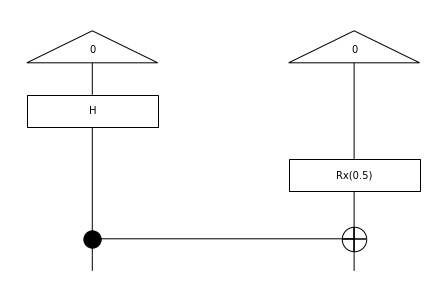

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[4.32978028e-17+0.j    , 0.00000000e+00-0.70710678j,
 0.00000000e+00-0.70710678j, 4.32978028e-17+0.j    ])


In [5]:
#"purr". Two outputs to offer opportunity of connecting to _and
def intransitive_ansatz(phase):
    return Ket(0, 0) >> H @ Rx(phase) >> CX

iv = intransitive_ansatz(0.5)
iv.draw(aspect='auto', draw_type_labels=False)
print(iv.eval())

Circuit for the transitive ansatz state:

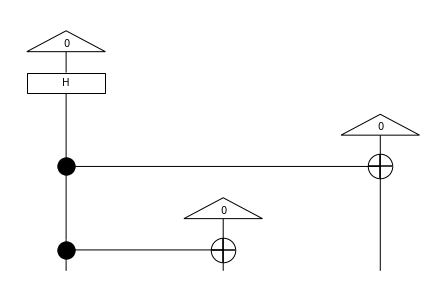

Tensor(dom=Dim(1), cod=Dim(2, 2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j])


In [6]:
#GHZ state. Output connects to subject, object and _and
def transitive_ansatz(phase):
    return Functor(ob=lambda o: o, ar=lambda a: a)(Spider(0, 3, s, phase=phase))

tv = transitive_ansatz(0.5)
tv.draw(aspect='auto', draw_type_labels=False)
print(tv.eval())

**5) We explicit the mapping for each entry in the vocabulary to their corresponding Quantum Circuits.**

In [7]:
ar = lambda params: {
    dogs: Ket(0),
    chase: transitive_ansatz(params['chase']),
    cats: Ket(1),
    _and: intransitive_ansatz(params['_and']),
    _or: intransitive_ansatz(params['_or']),
    _do_not: intransitive_ansatz(params['_do_not']),
    purr: intransitive_ansatz(params['purr'])}

**6) Because the circuit is parameterized, we define a function which takes a set of parameters as inputs and outputs a functor from the grammar category to the category of quantum circuits**

In [8]:
#F is a function which takes parameters and constructs a Functor
F = lambda params: CircuitFunctor(ob, ar({'chase': params[0], '_and': params[1], '_or': params[2], '_do_not': params[3], 'purr': params[4]}))

**7) Another functor is created to evaluate the circuit**

In [9]:
#We evaluate the circuit through applying another functor:
evaluate = lambda F, sentence: F(sentences2diagram[sentence]).measure()

**8) We download the csv giving the truth value of each sentence**

dogs purr


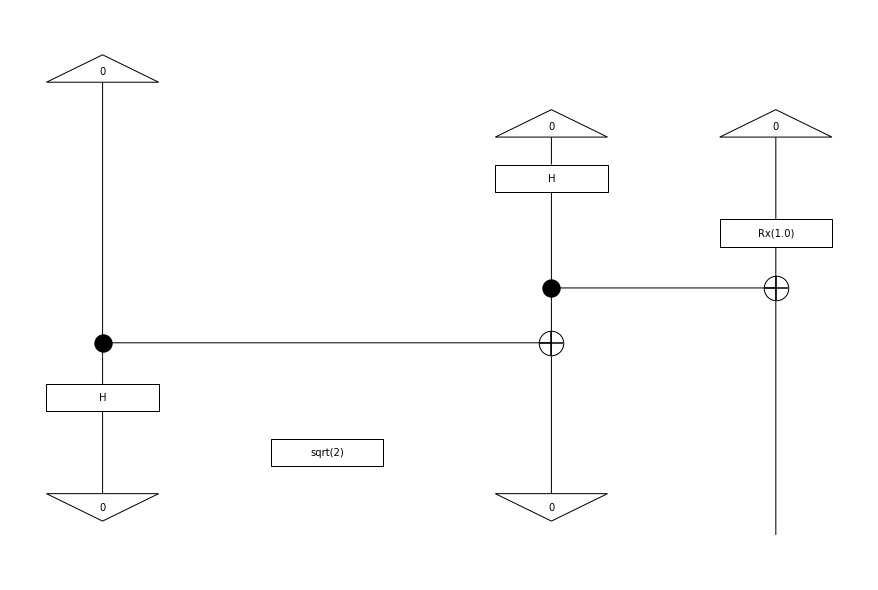


cats purr


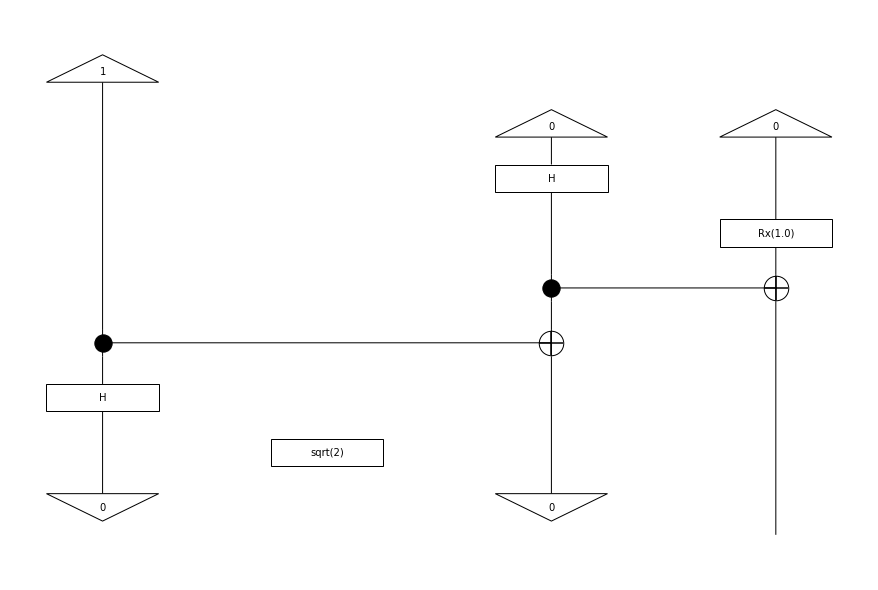


dogs chase dogs


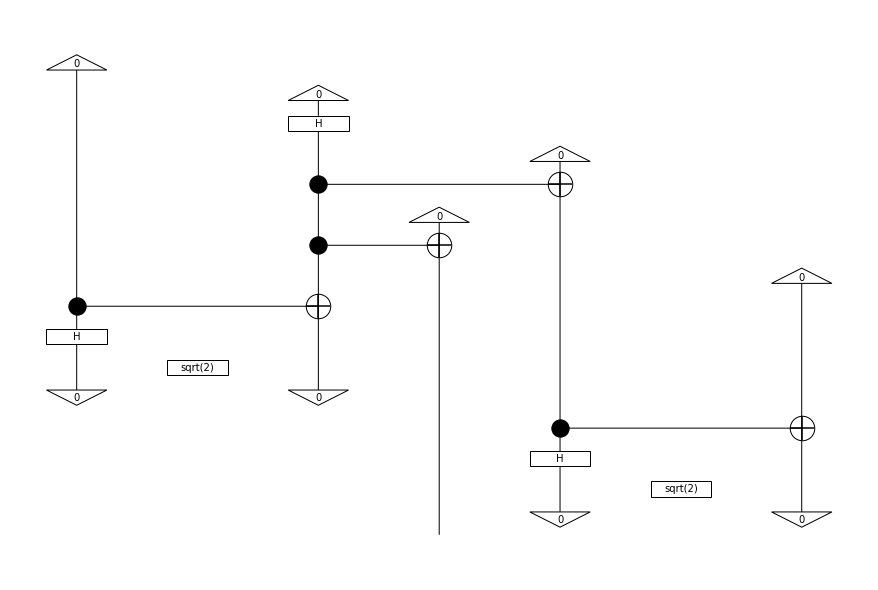


dogs chase cats


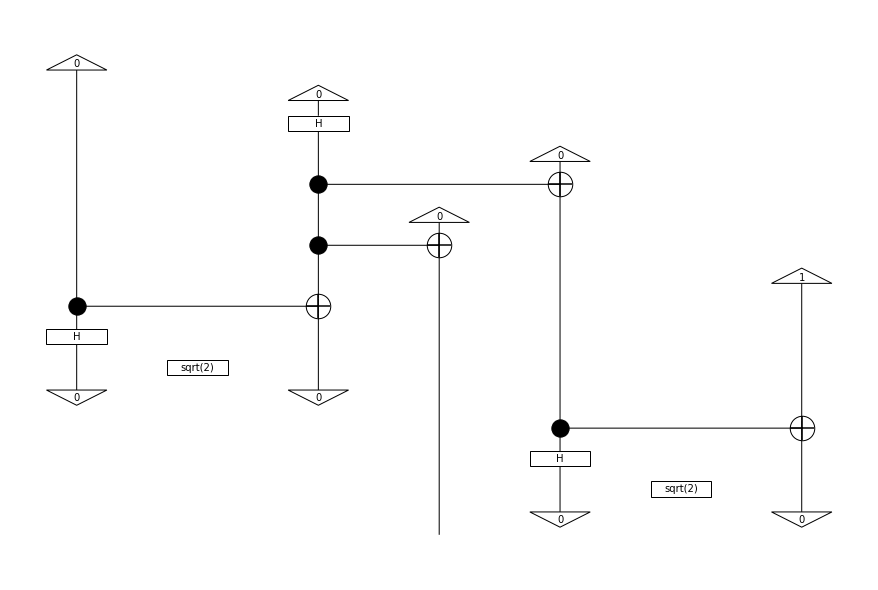


dogs don't purr


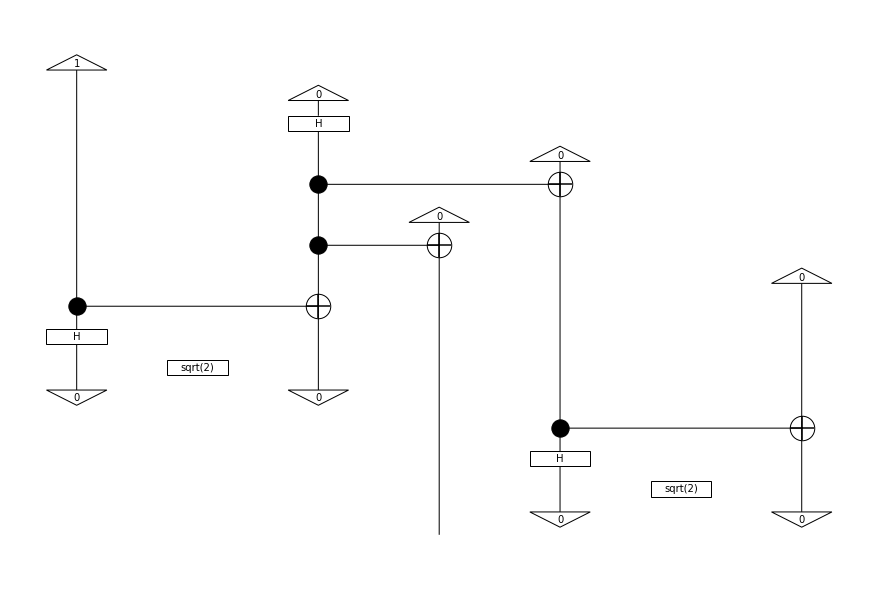


cats chase dogs


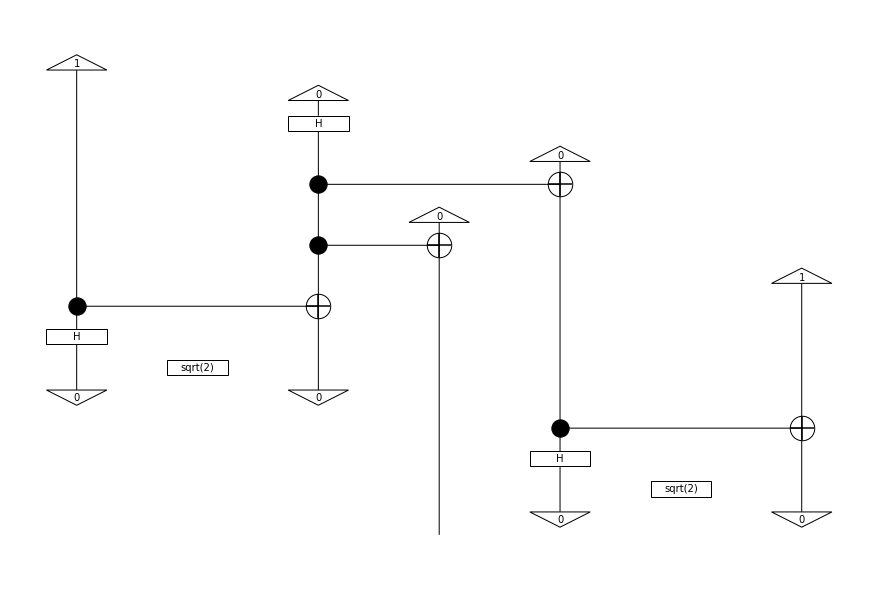


cats chase cats


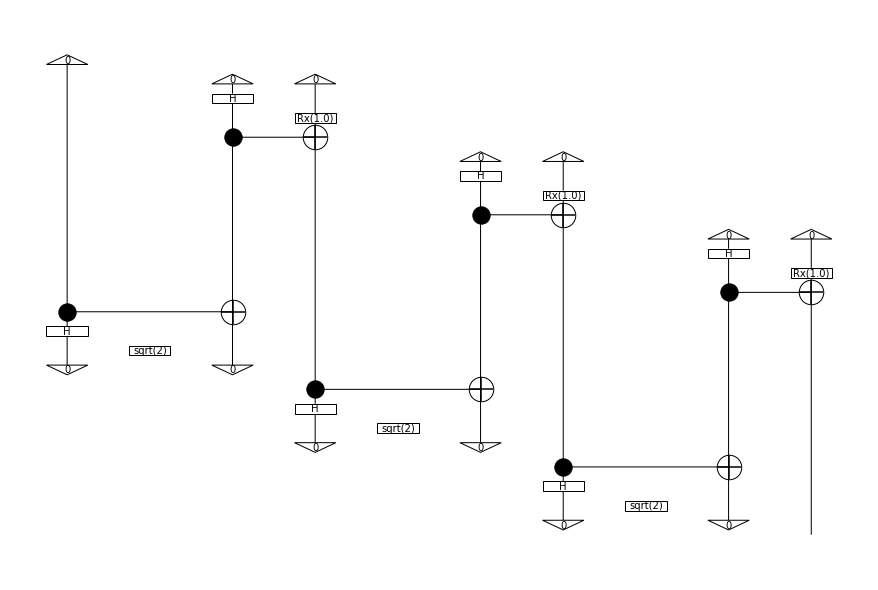


cats don't purr


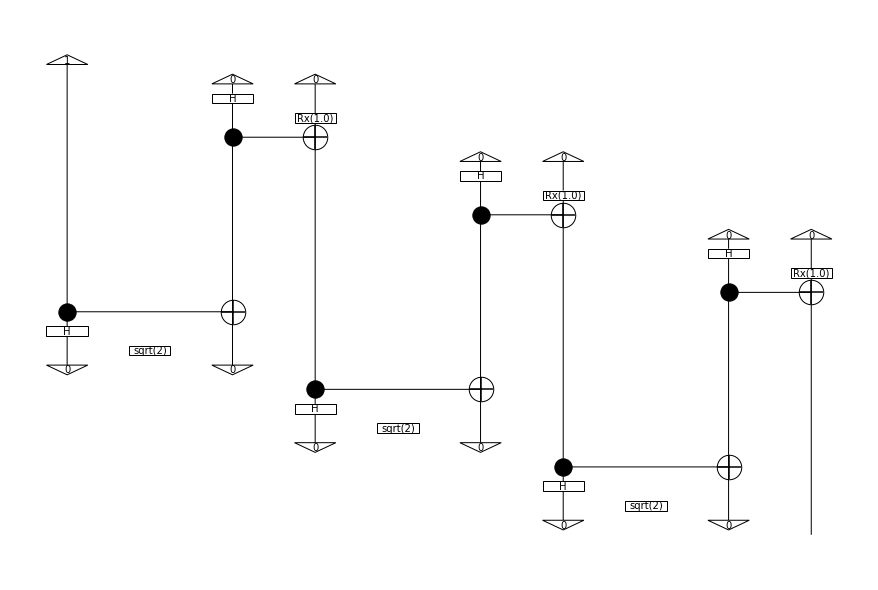


dogs don't chase dogs


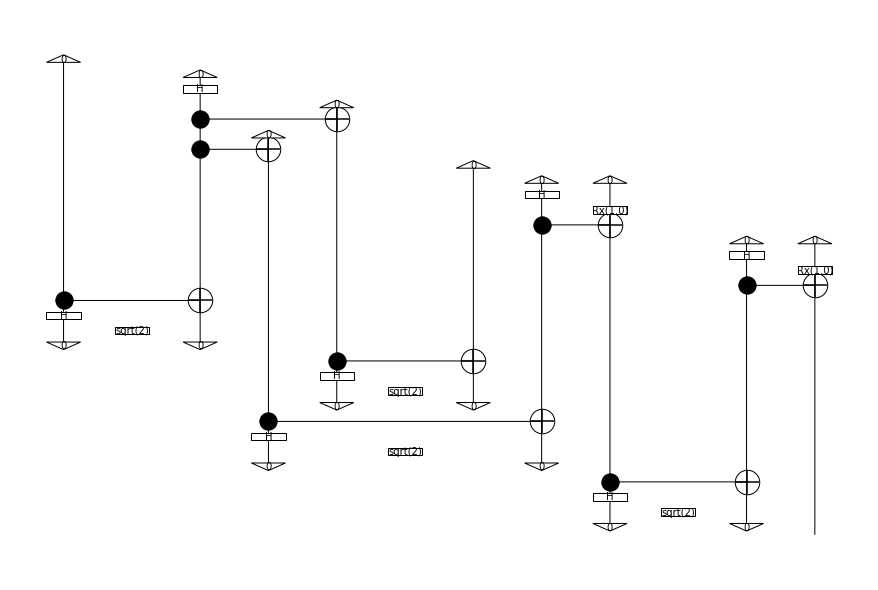


dogs don't chase cats


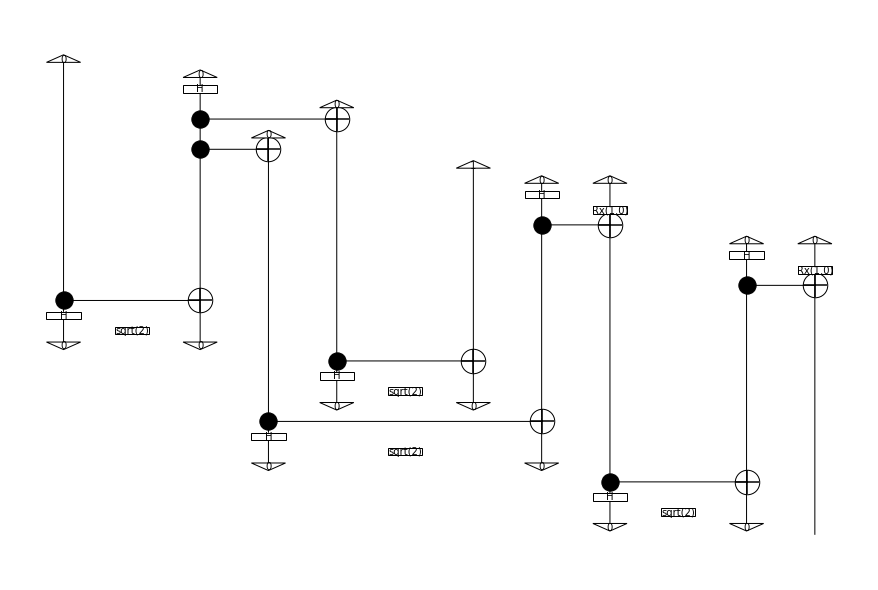


dogs don't don't purr


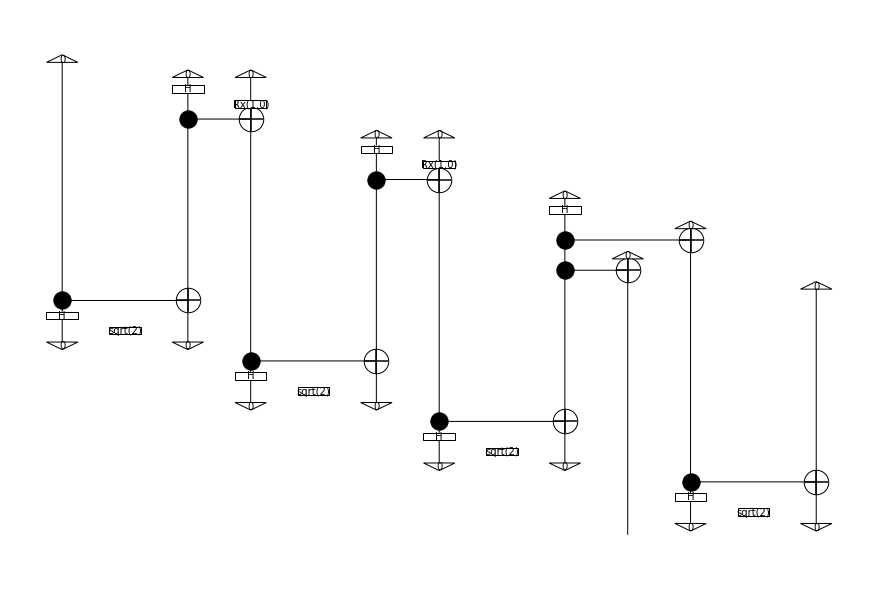


dogs purr and purr


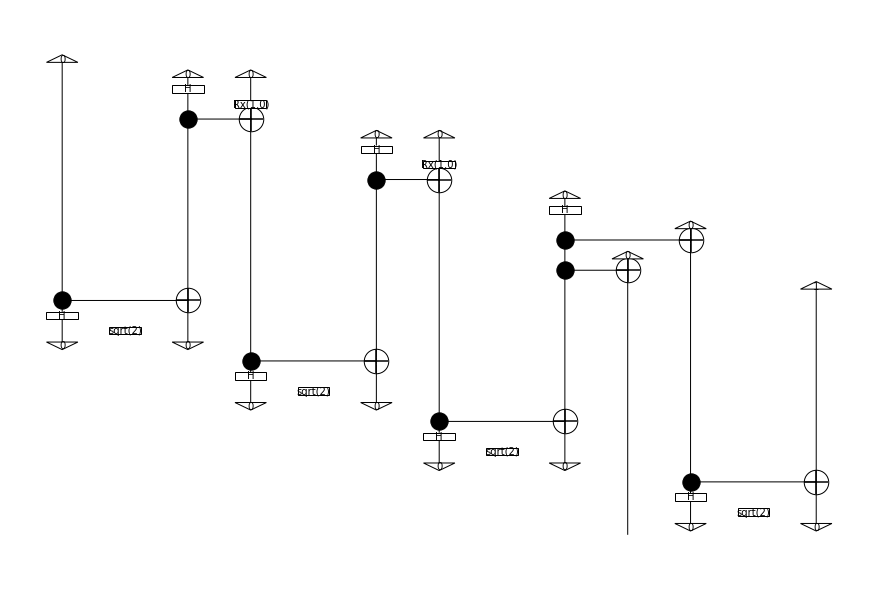


dogs purr or purr


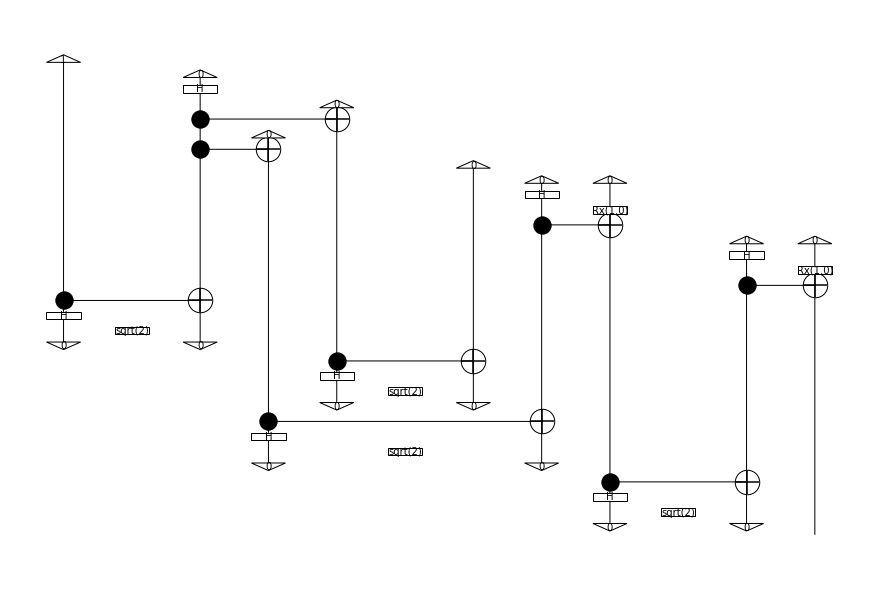


cats don't chase dogs


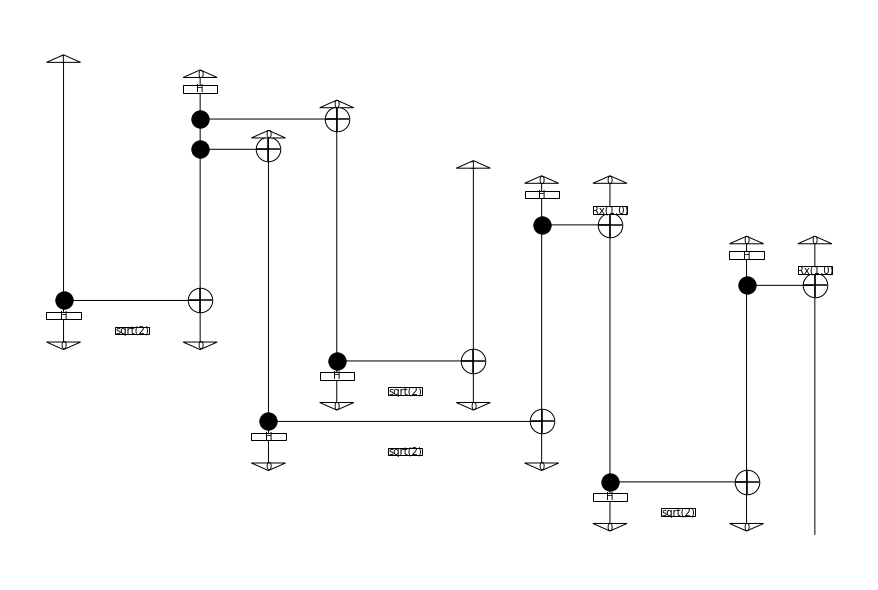


cats don't chase cats


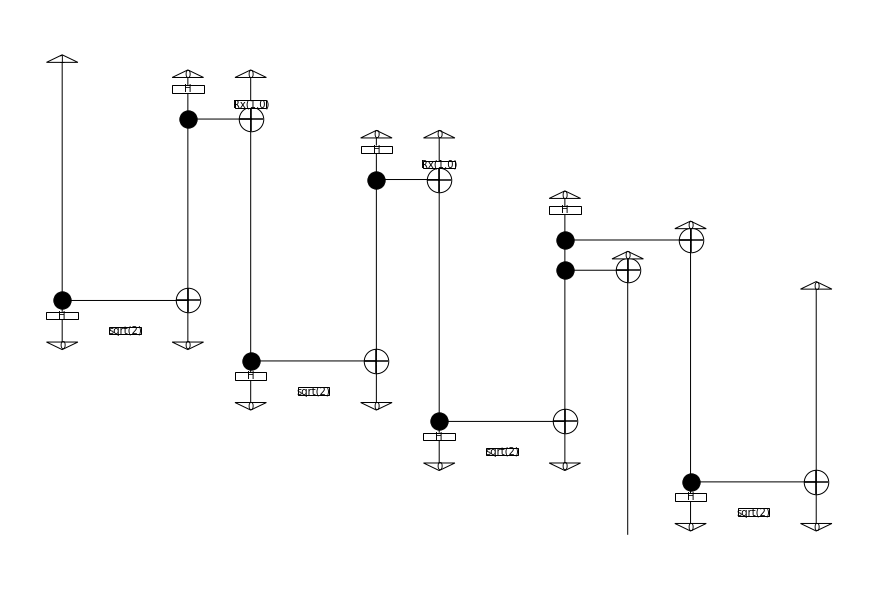


cats don't don't purr


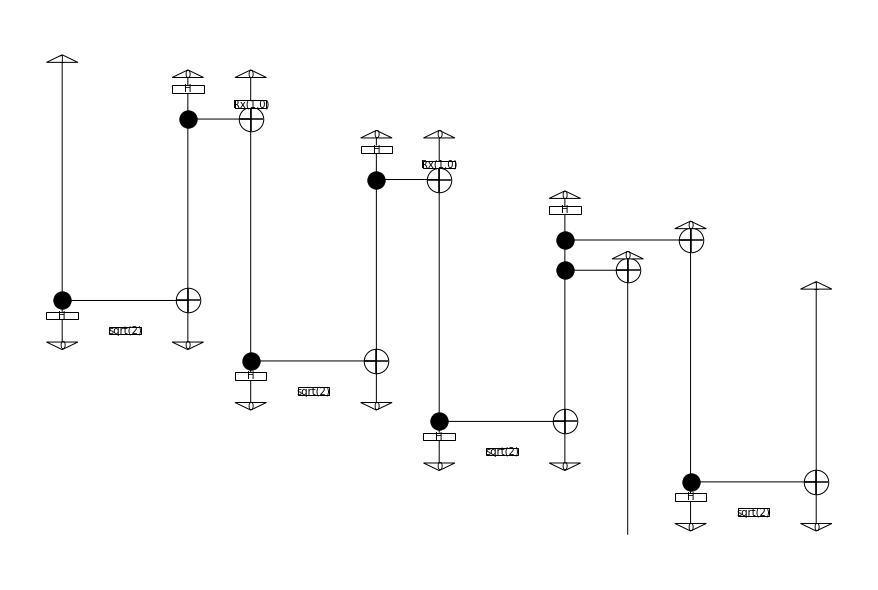


cats purr and purr


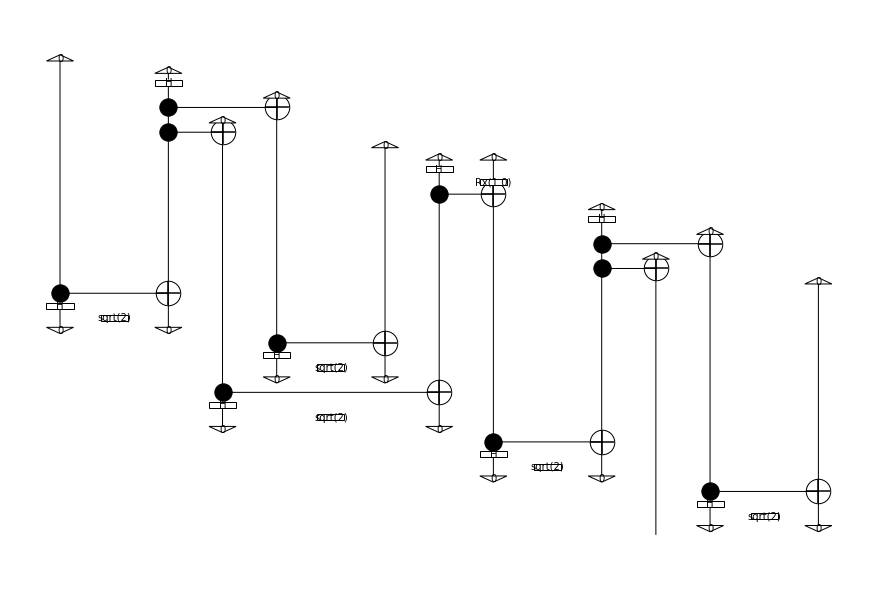


cats purr or purr


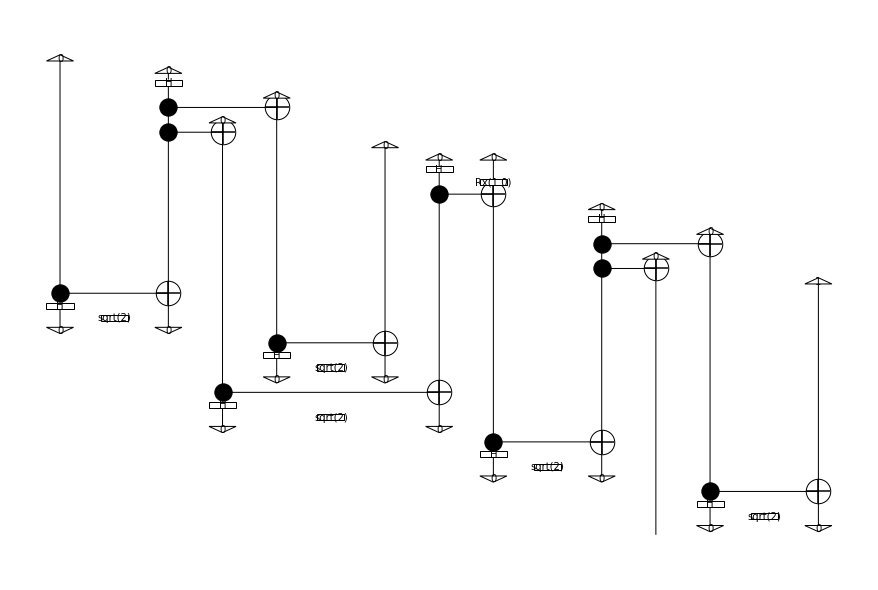


dogs chase dogs and purr


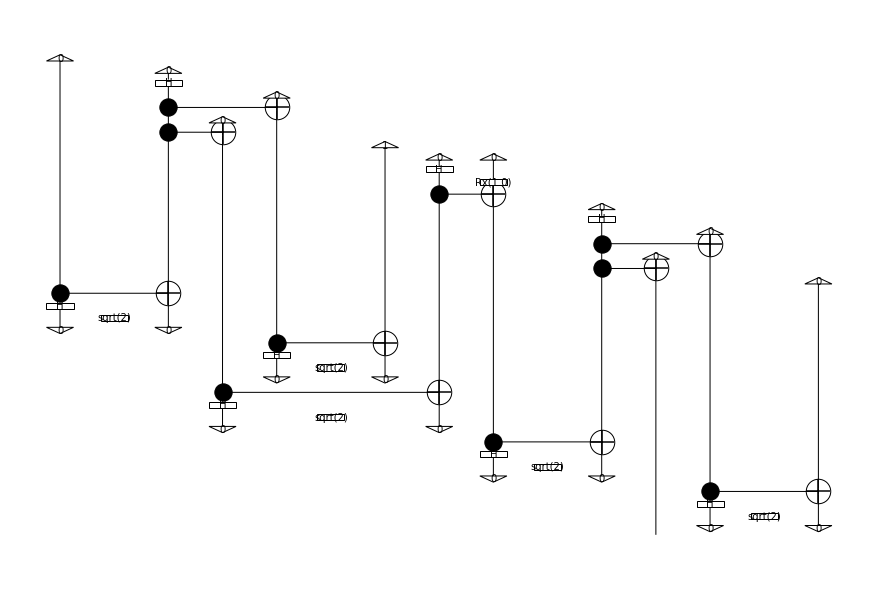


dogs chase dogs or purr


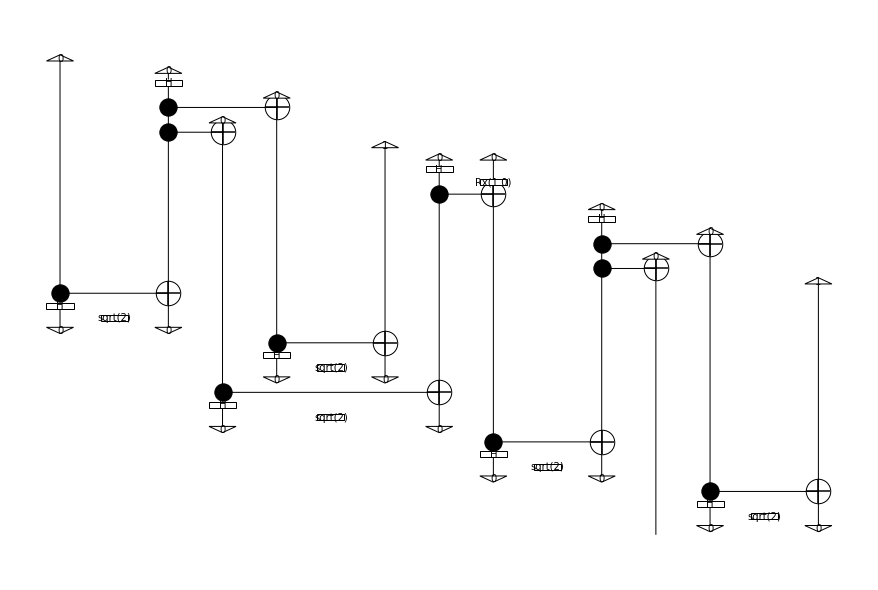


dogs chase cats and purr


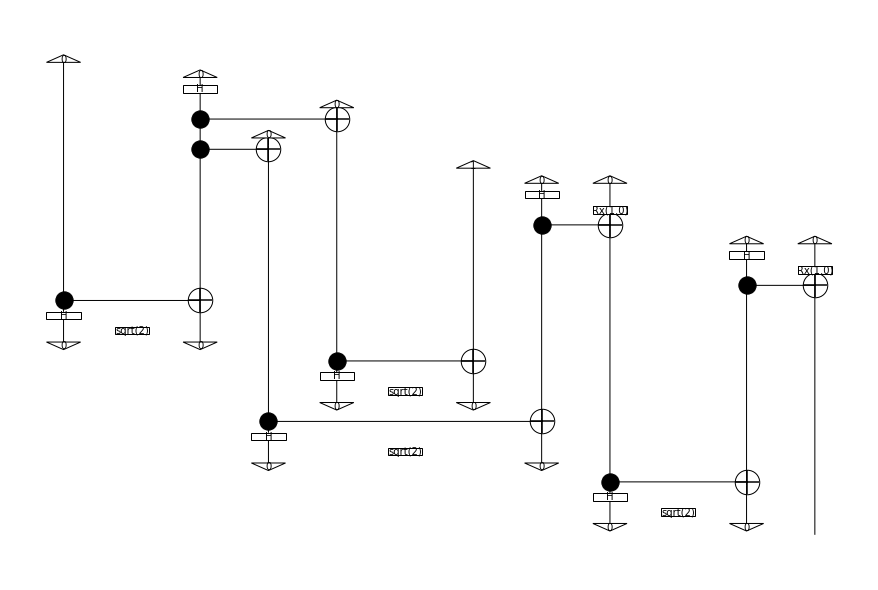


dogs chase cats or purr


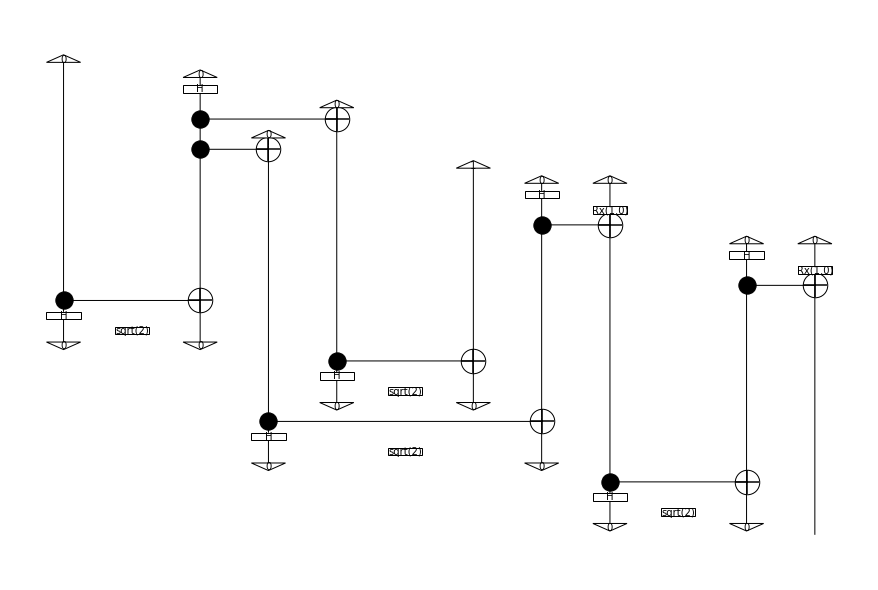


dogs don't don't chase dogs


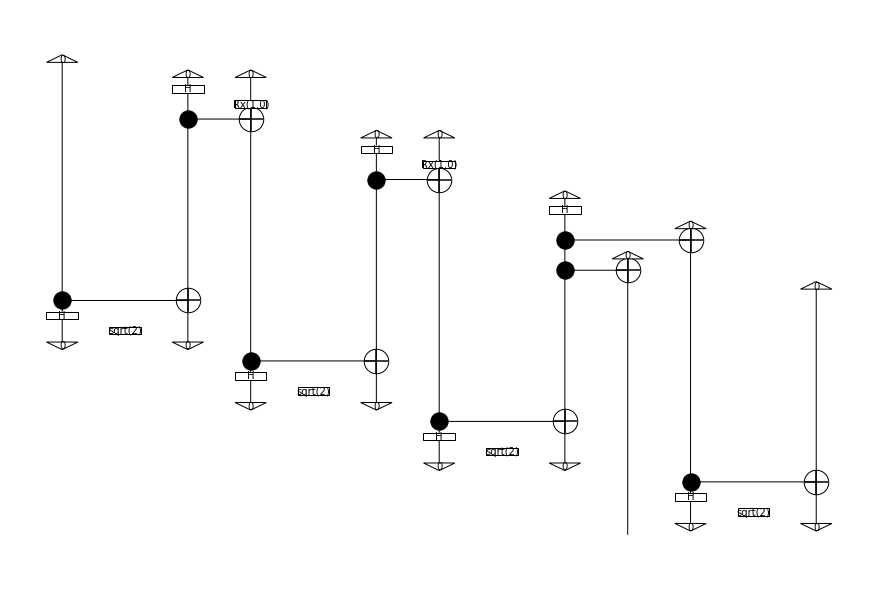


dogs don't don't chase cats


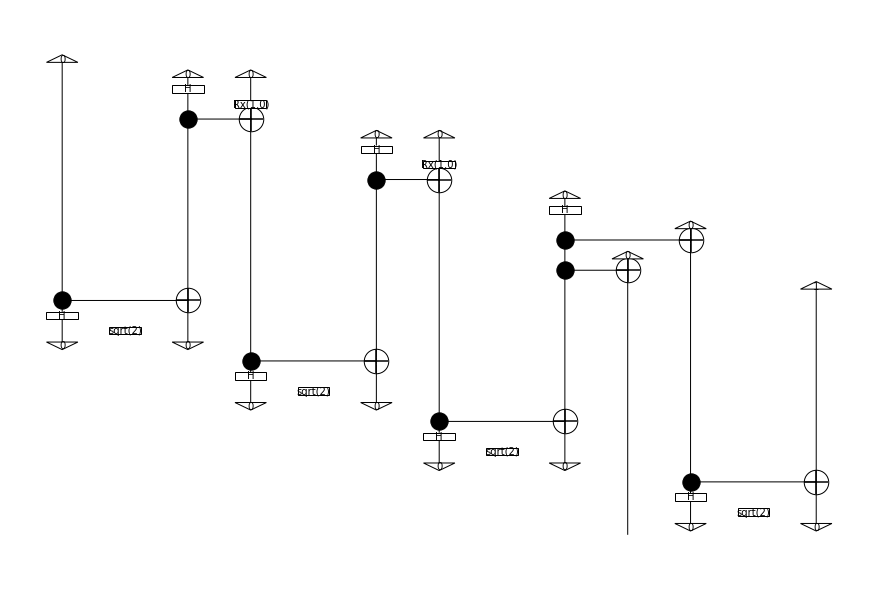


dogs don't don't don't purr


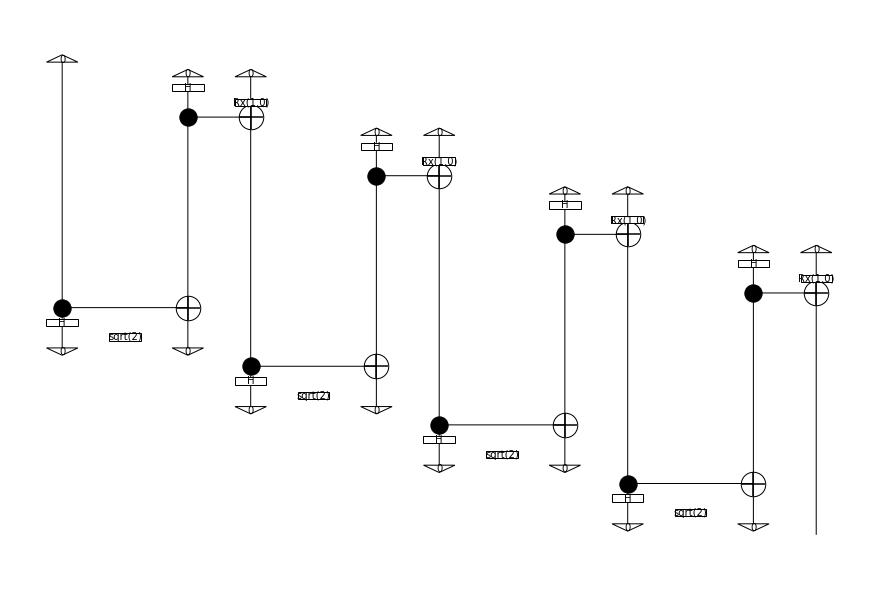


dogs don't purr and purr


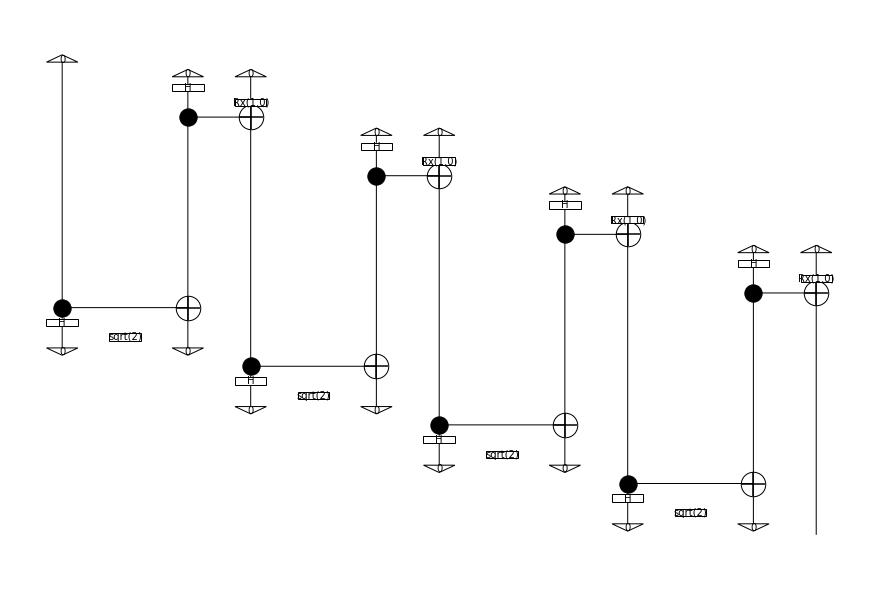


dogs don't purr or purr


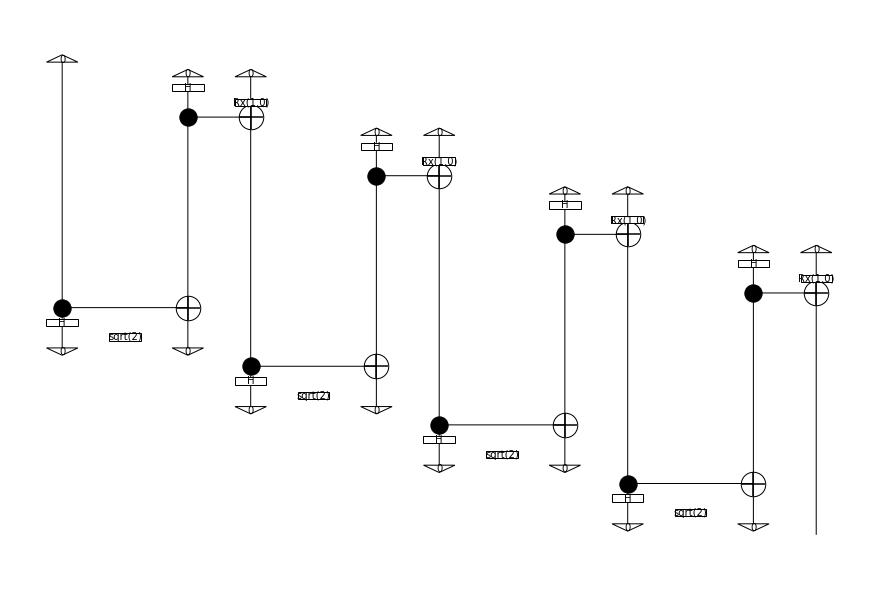


dogs purr and chase dogs


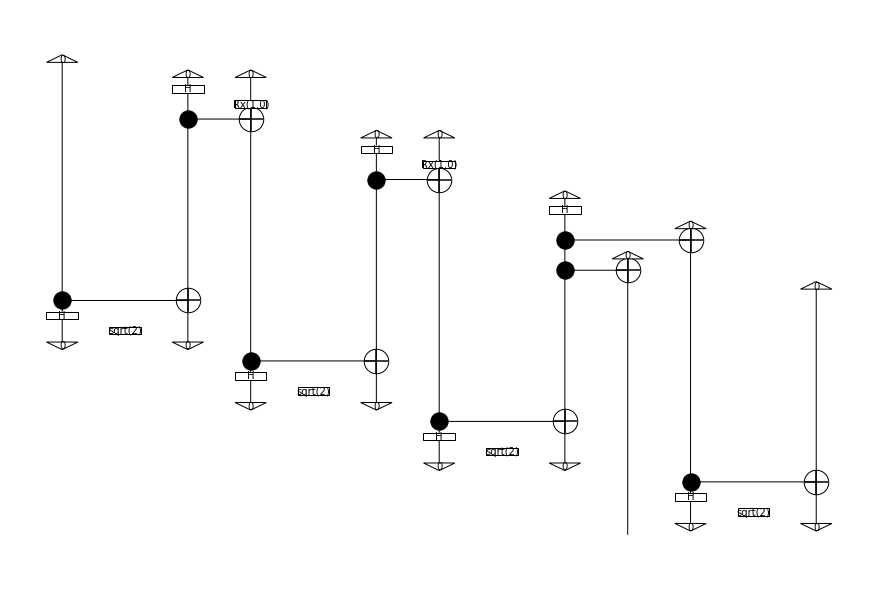


dogs purr and chase cats


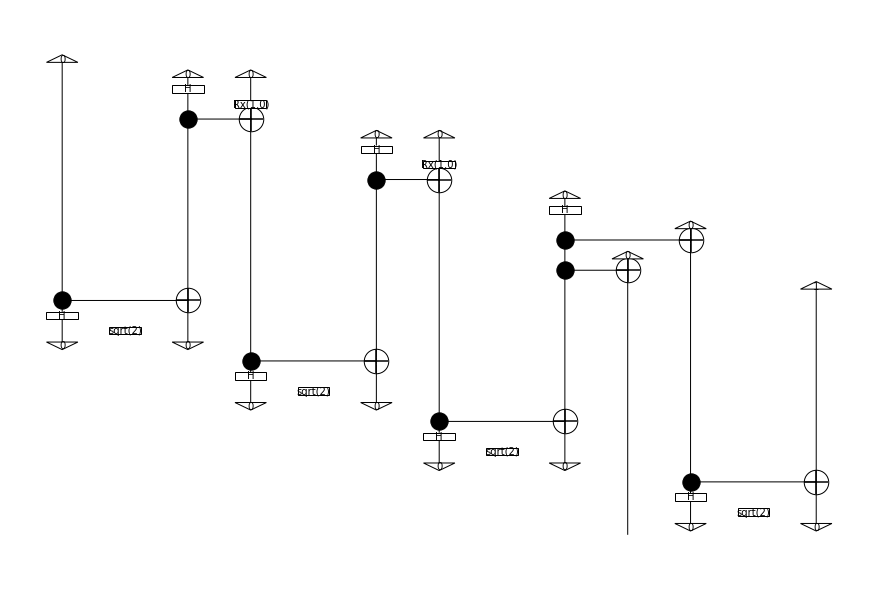


dogs purr and don't purr


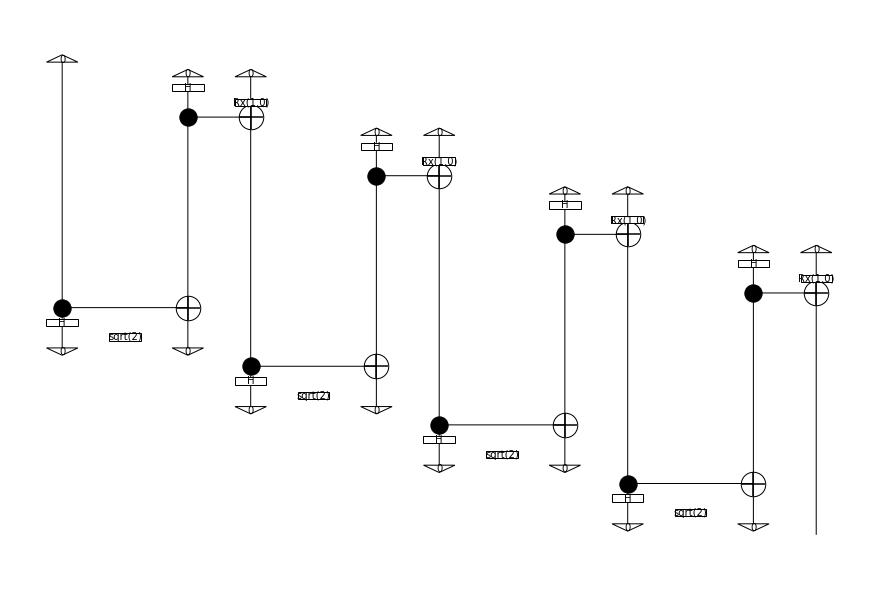


dogs purr or chase dogs


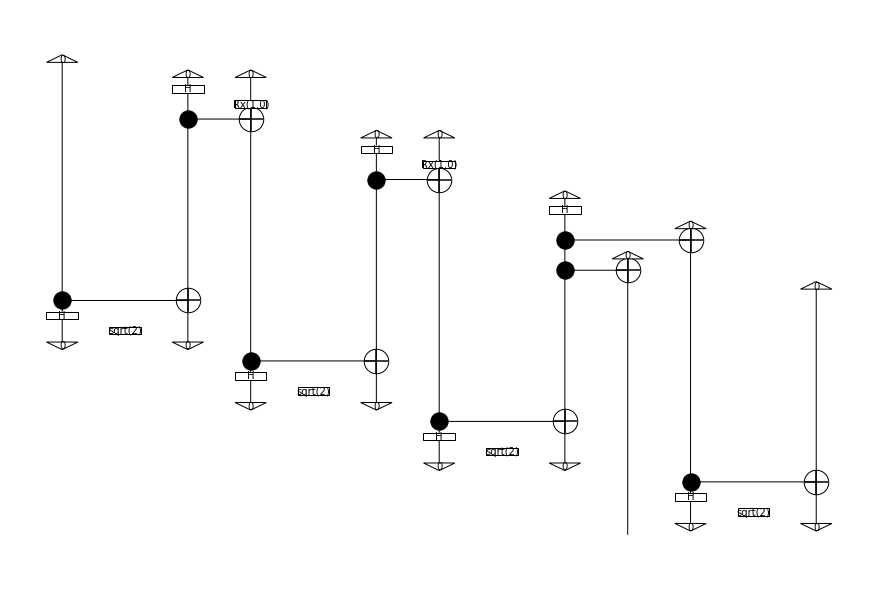


dogs purr or chase cats


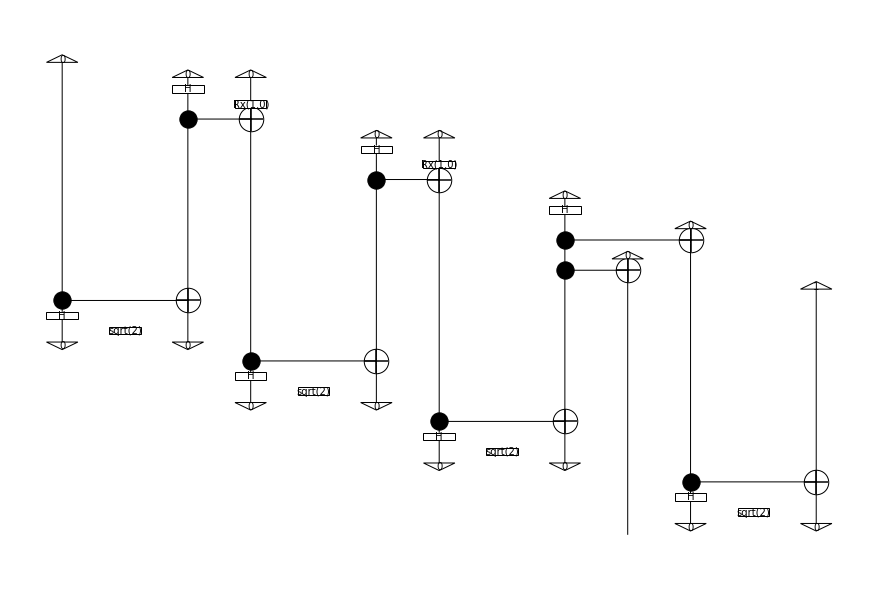


dogs purr or don't purr


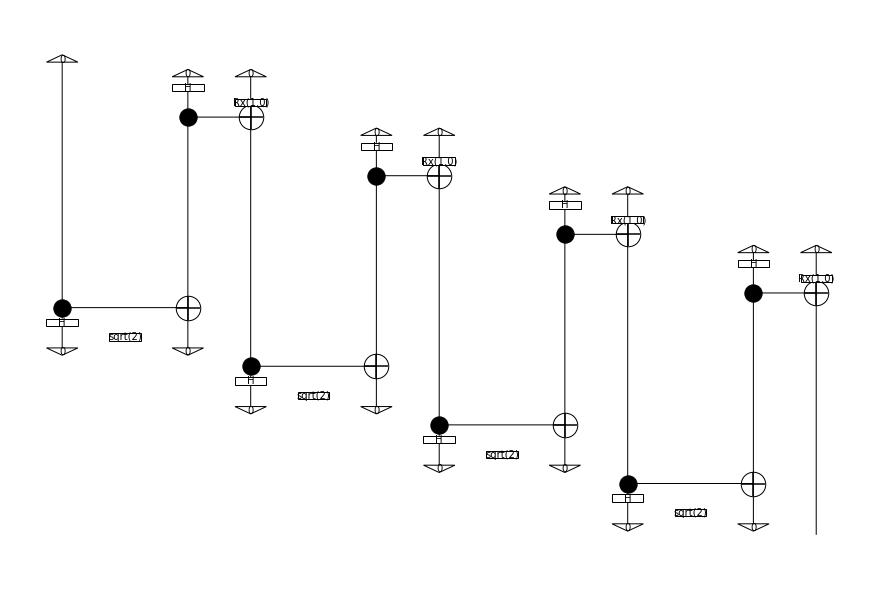


cats chase dogs and purr


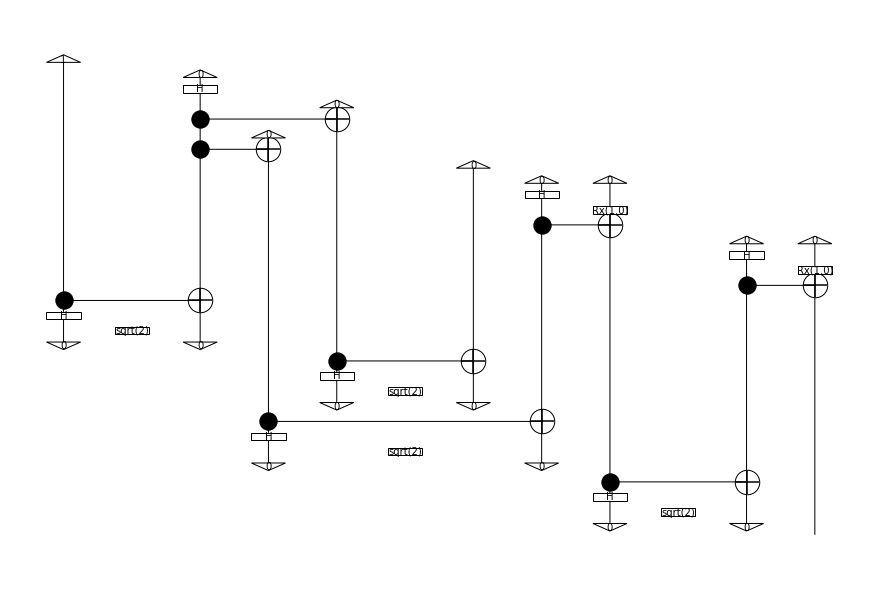


cats chase dogs or purr


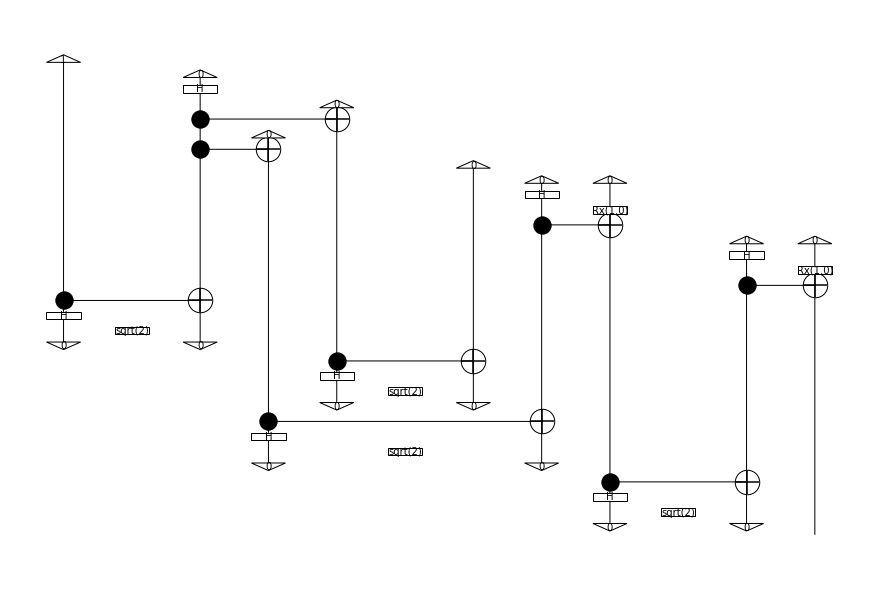


cats chase cats and purr


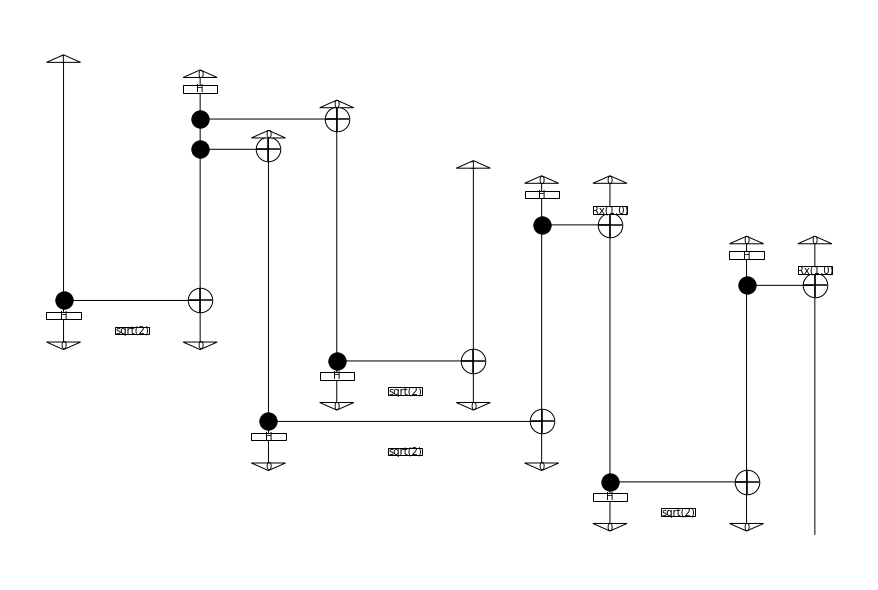


cats chase cats or purr


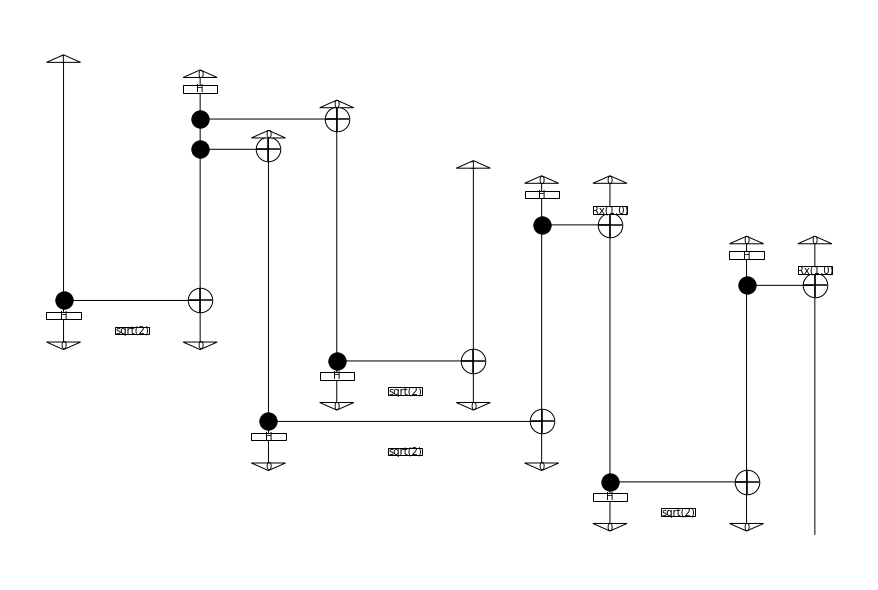


cats don't don't chase dogs


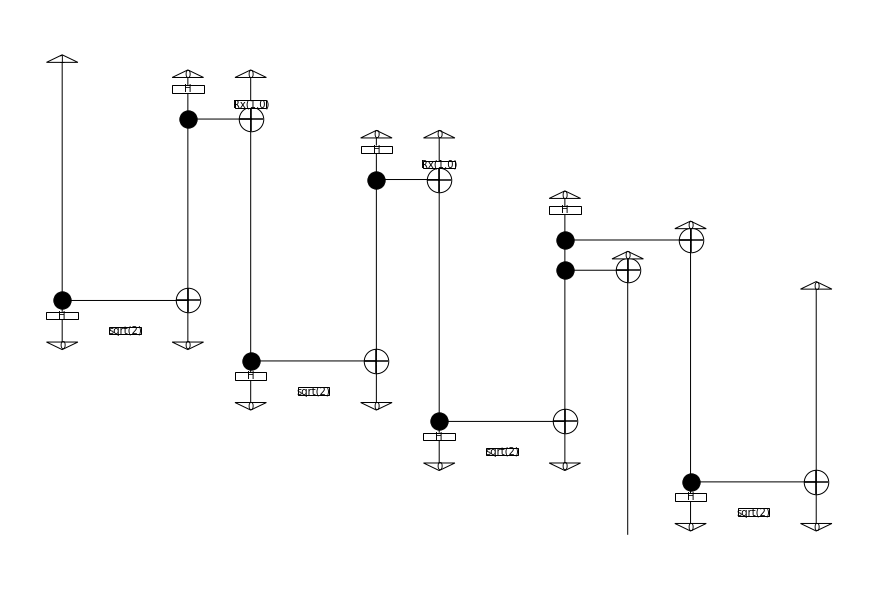


cats don't don't chase cats


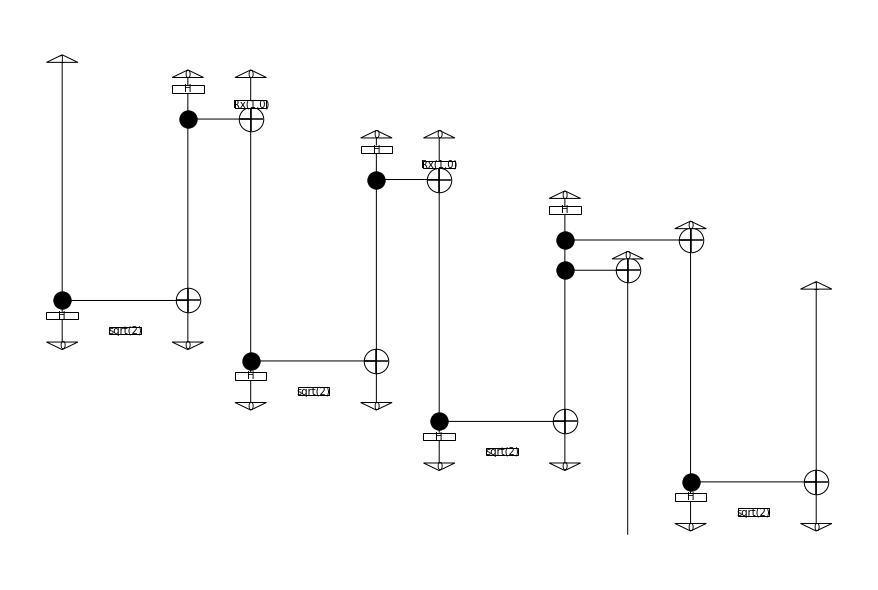


cats don't don't don't purr


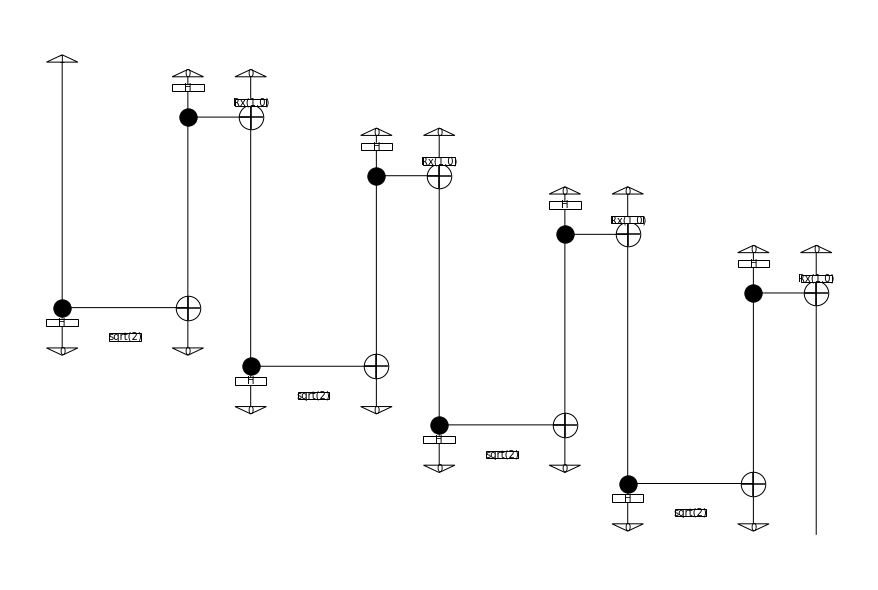


cats don't purr and purr


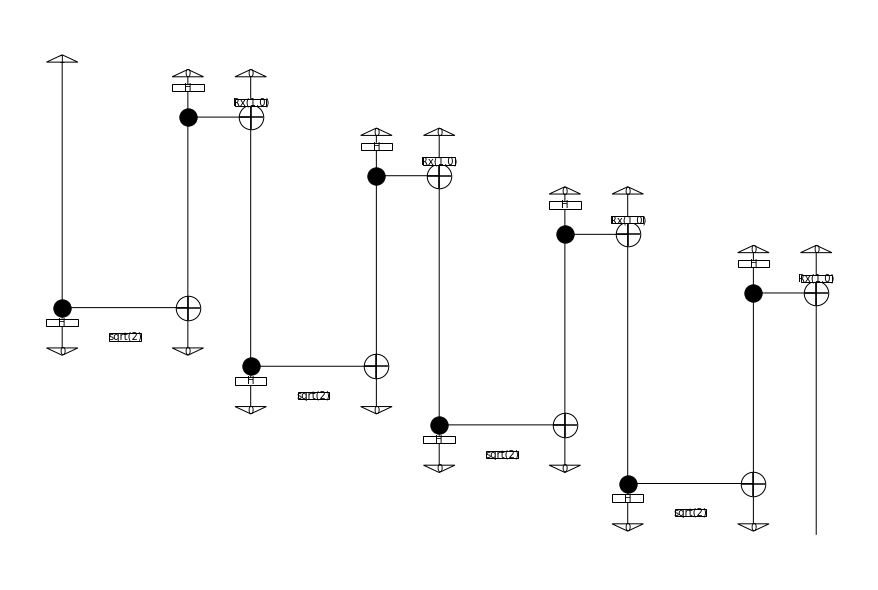


cats don't purr or purr


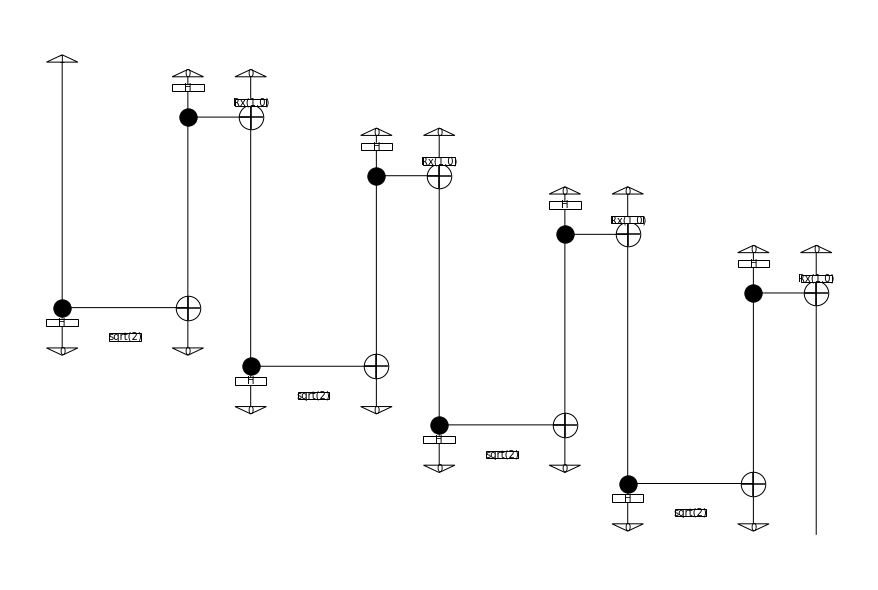


cats purr and chase dogs


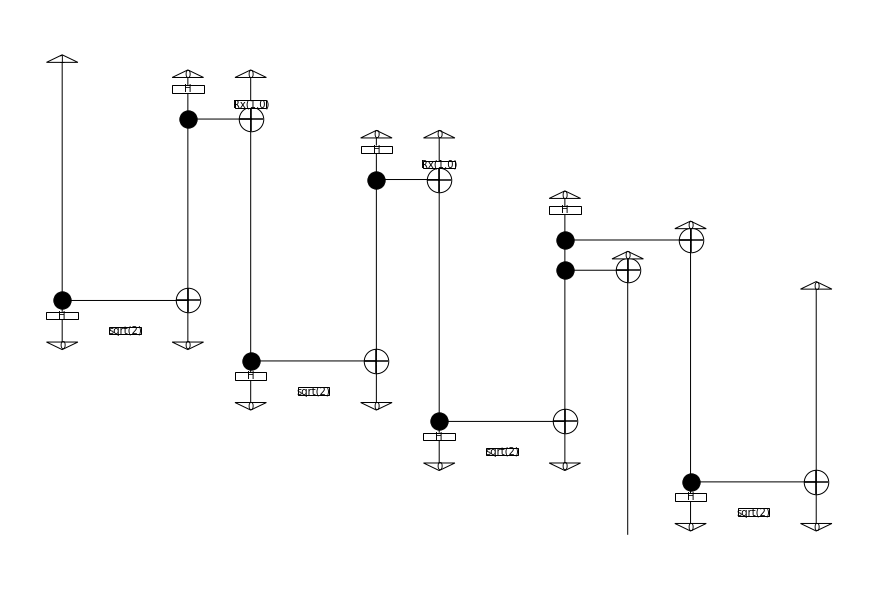


cats purr and chase cats


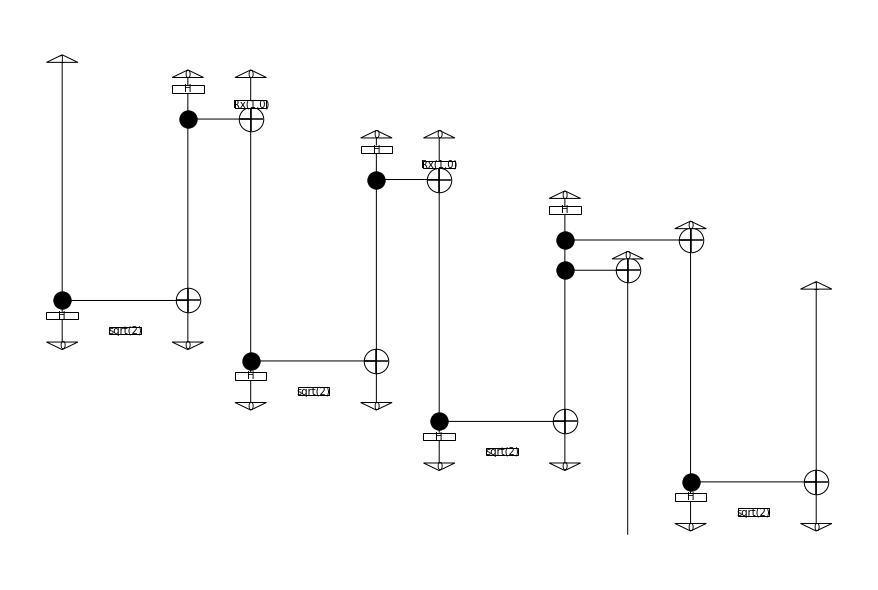


cats purr and don't purr


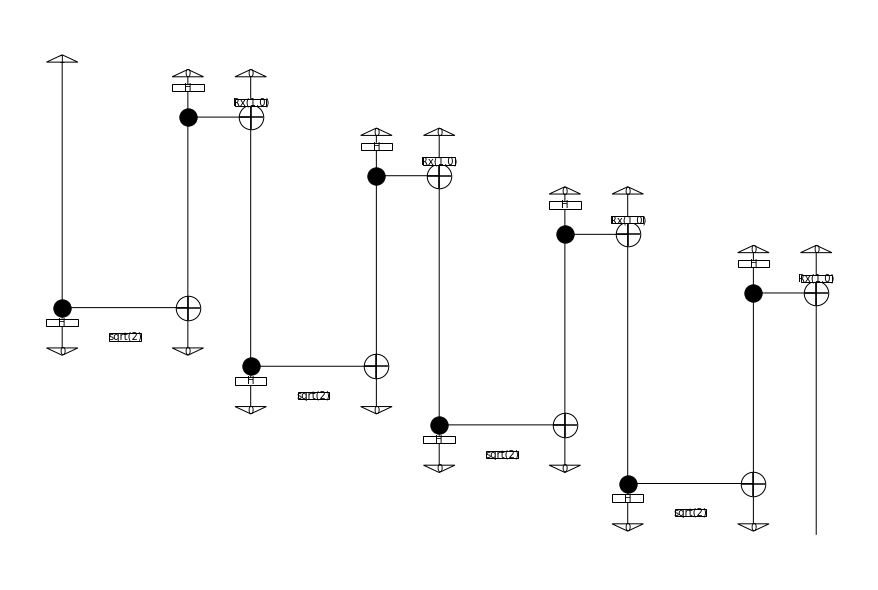


cats purr or chase dogs


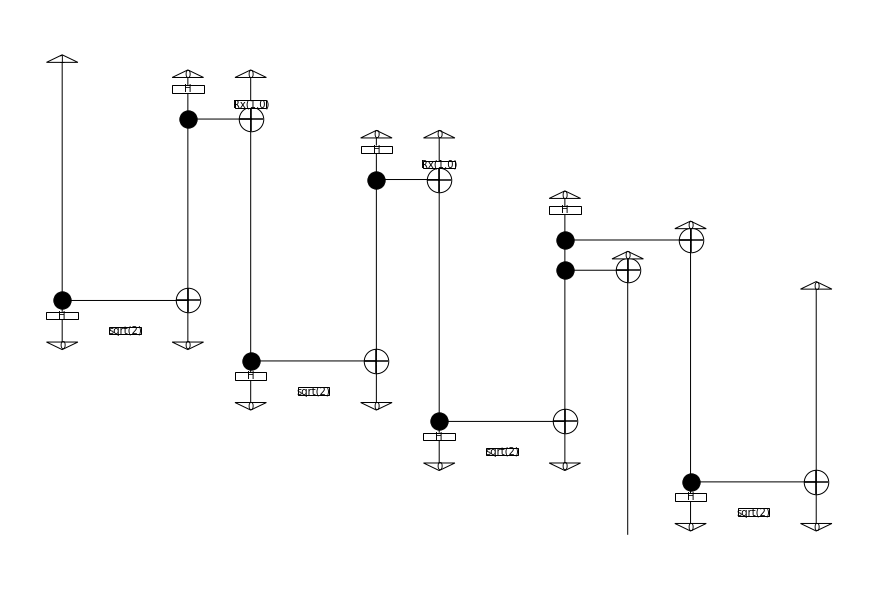


cats purr or chase cats


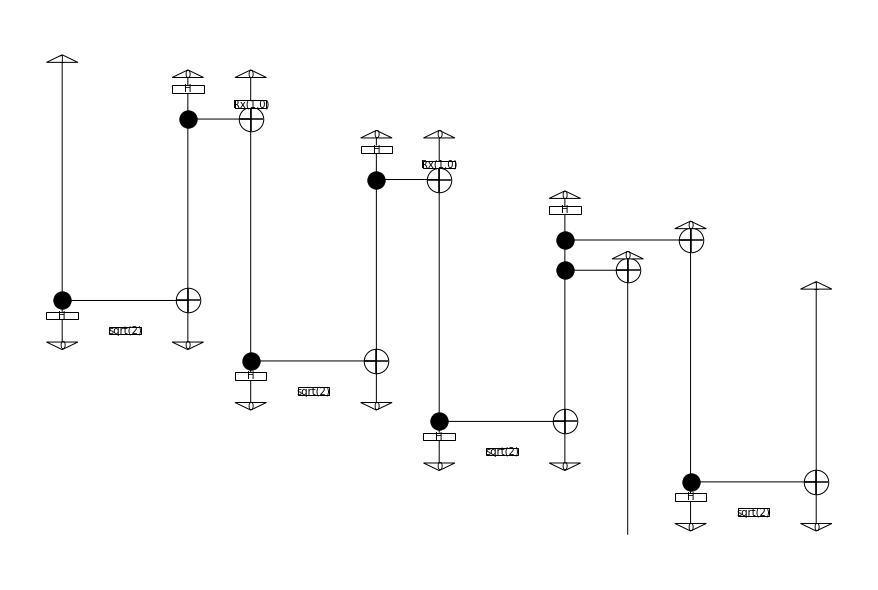


cats purr or don't purr


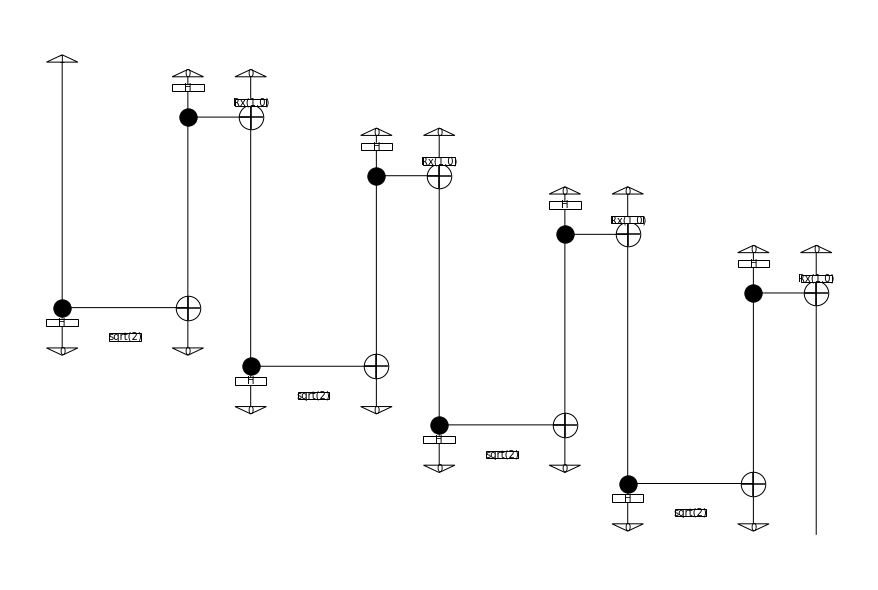


dogs chase dogs and chase dogs


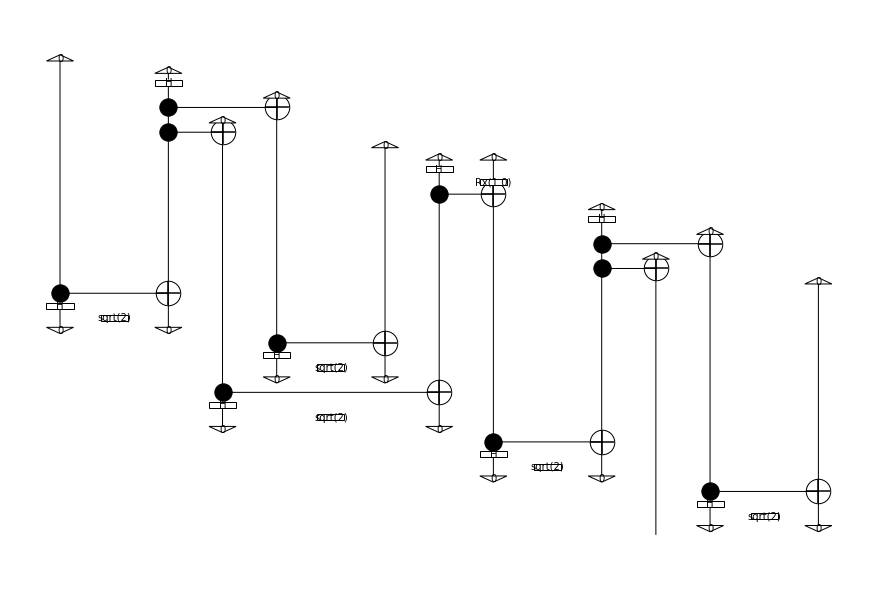


dogs chase dogs and chase cats


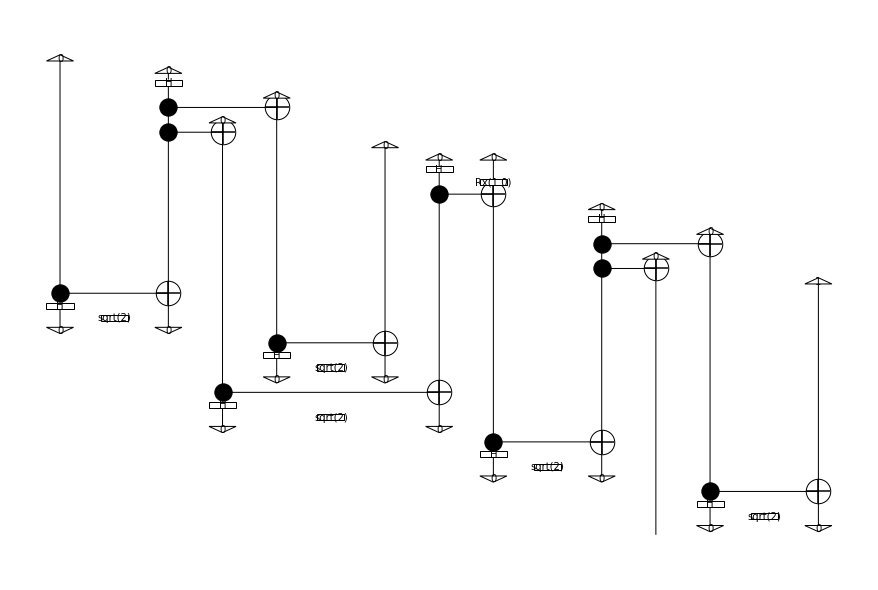


dogs chase dogs and don't purr


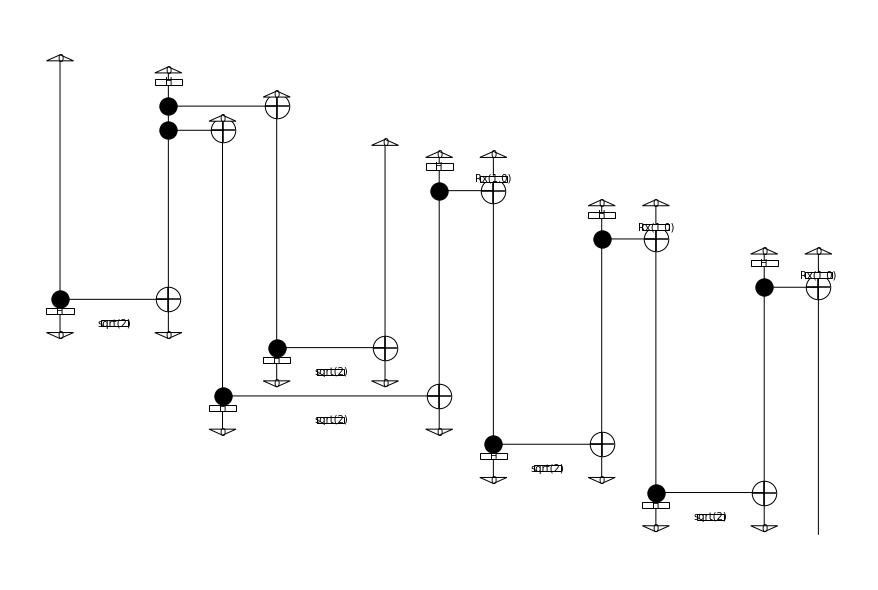


dogs chase dogs or chase dogs


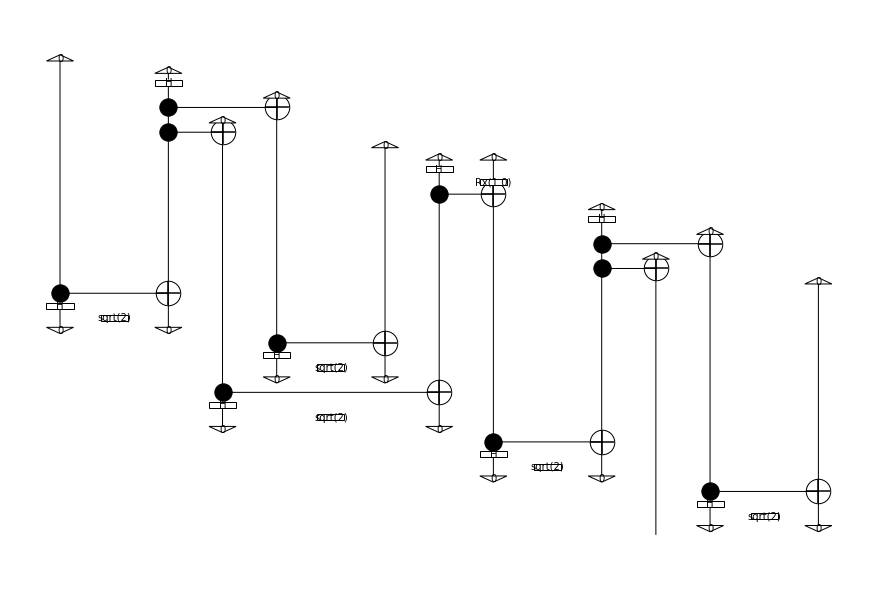


dogs chase dogs or chase cats


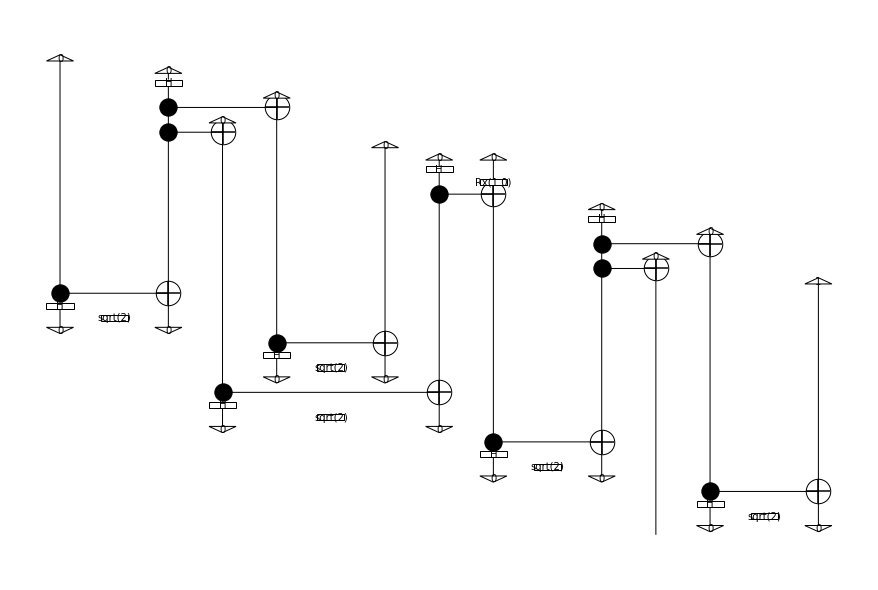


dogs chase dogs or don't purr


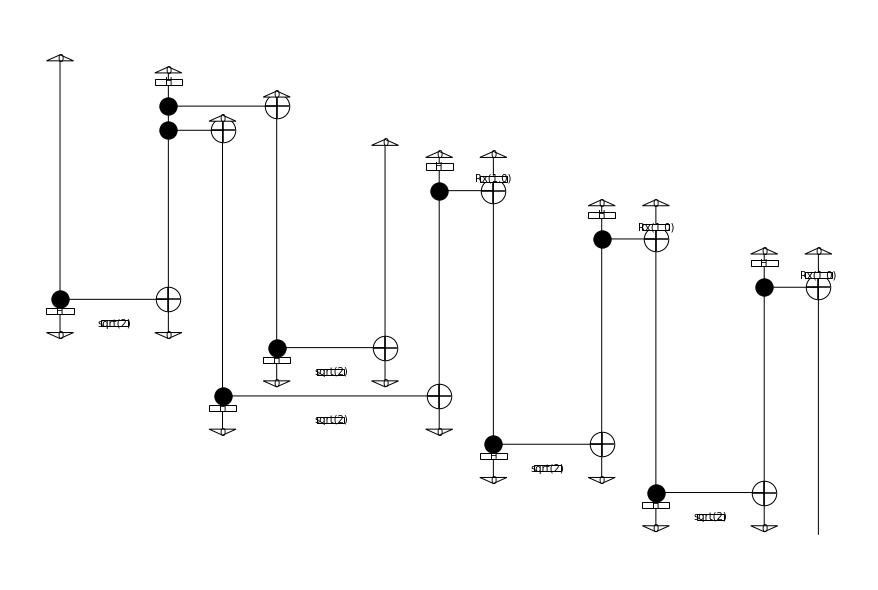


dogs chase cats and chase dogs


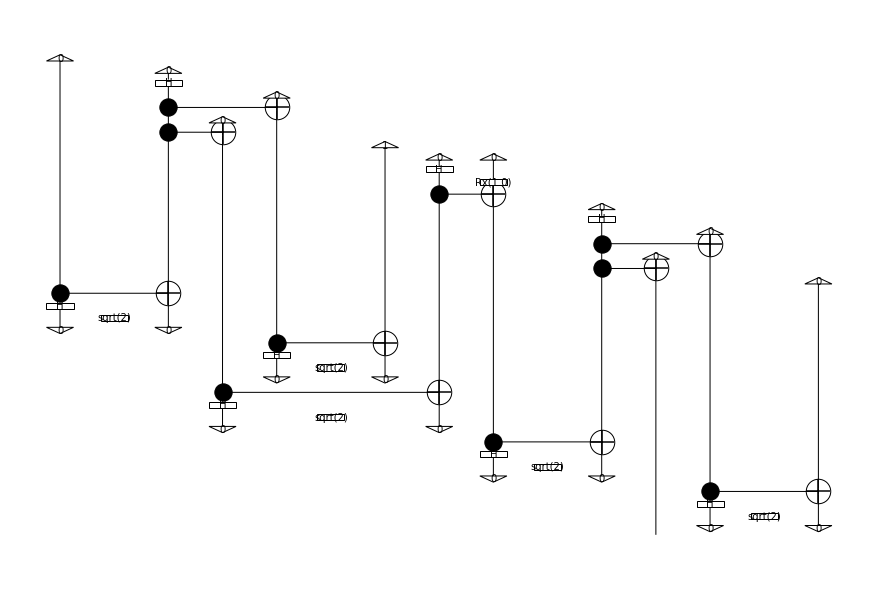


dogs chase cats and chase cats


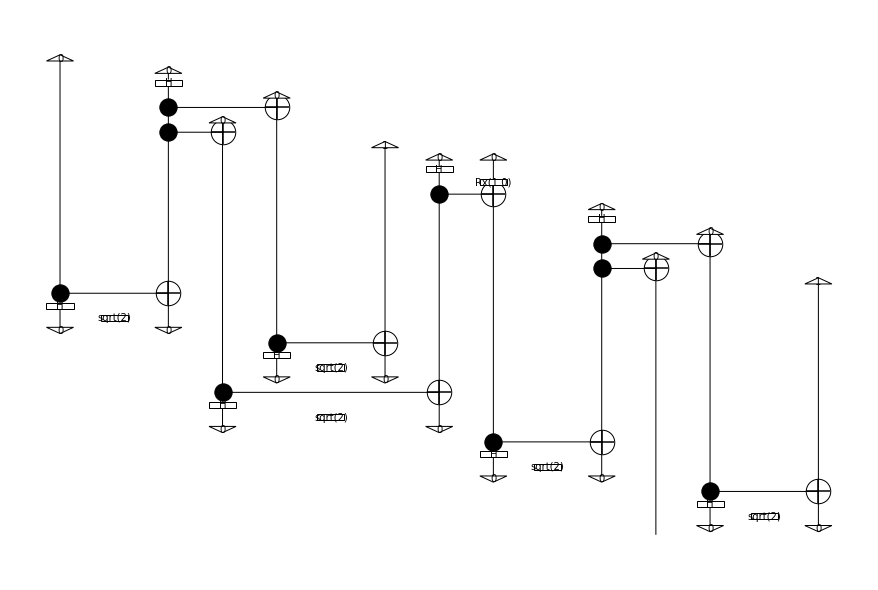


dogs chase cats and don't purr


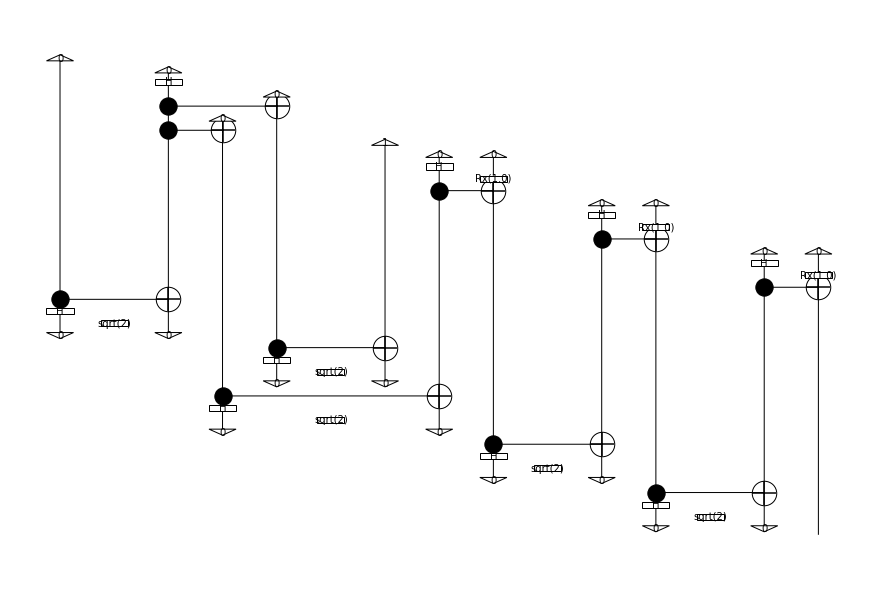


dogs chase cats or chase dogs


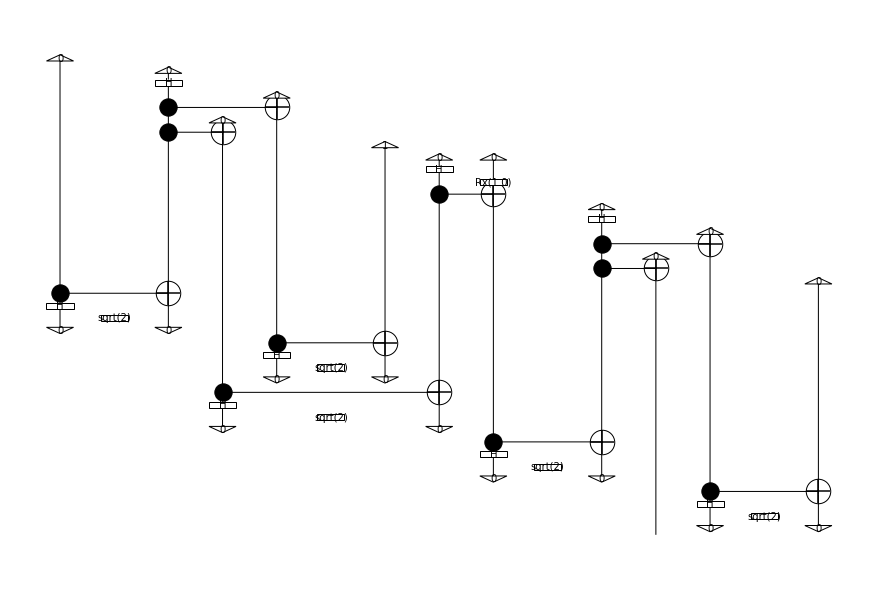


dogs chase cats or chase cats


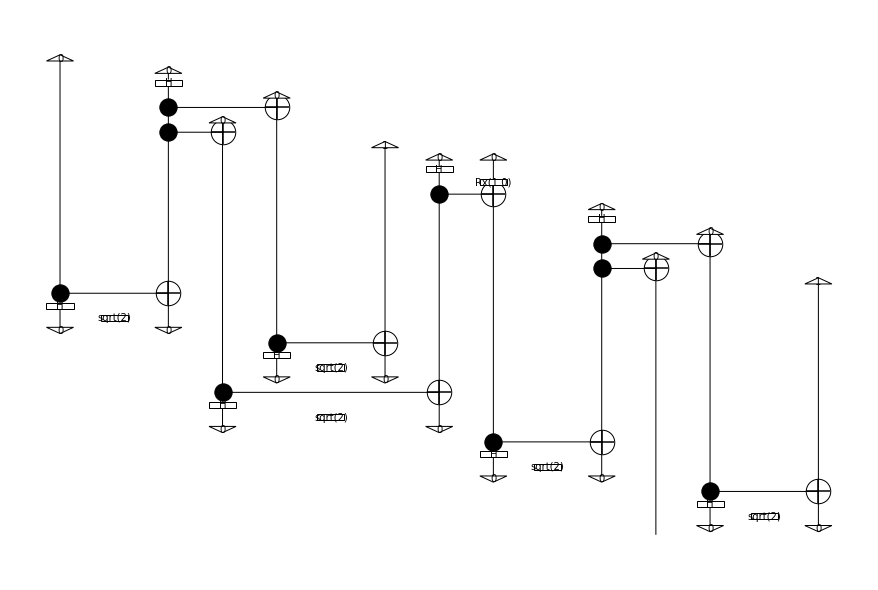


dogs chase cats or don't purr


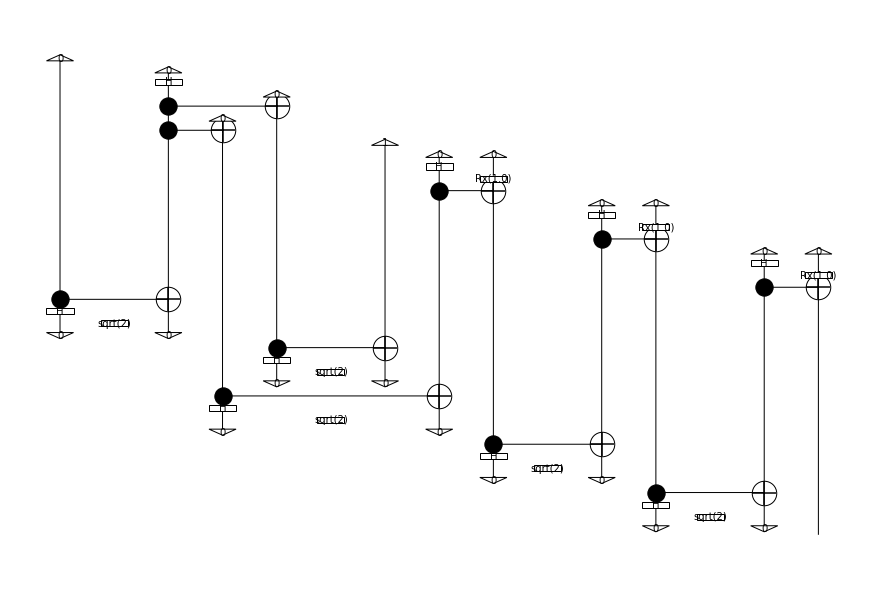


dogs don't chase dogs and purr


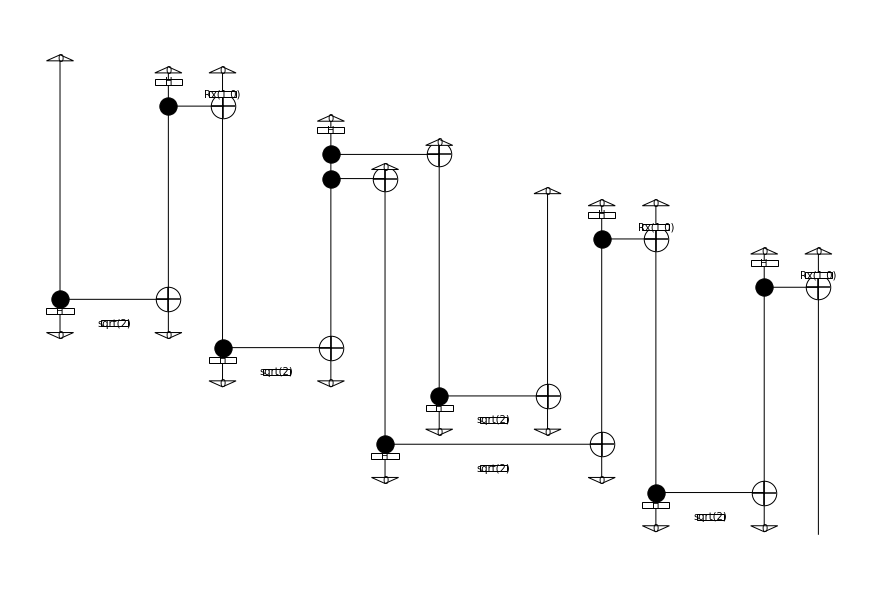


dogs don't chase dogs or purr


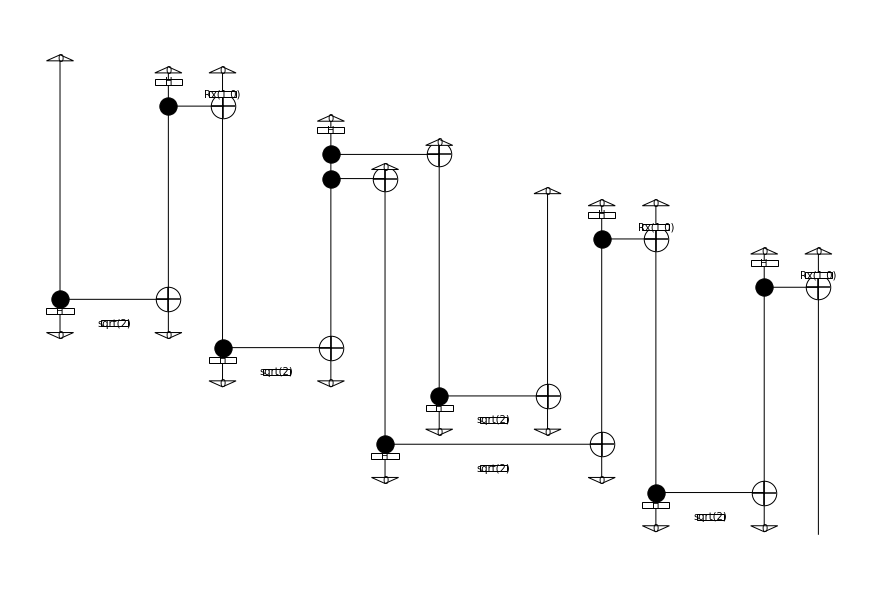


dogs don't chase cats and purr


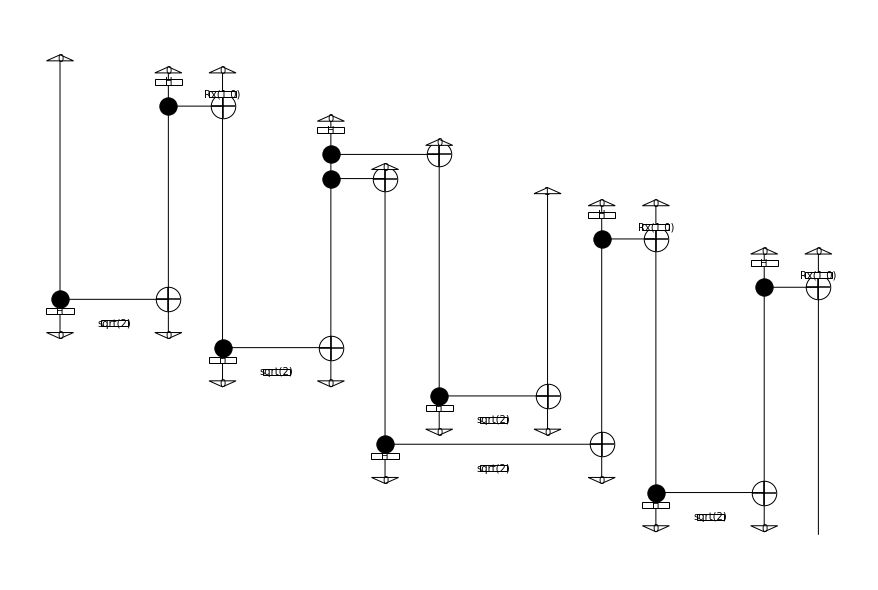


dogs don't chase cats or purr


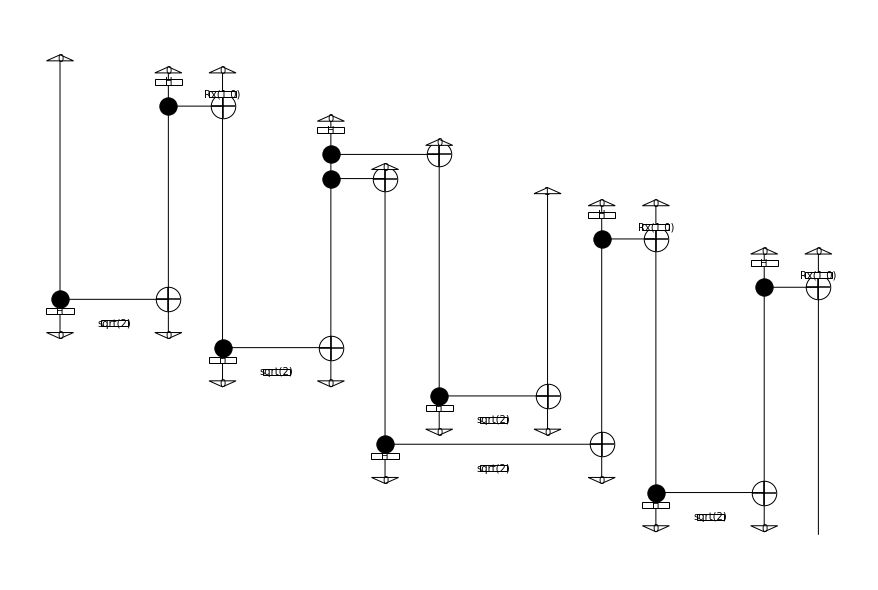


dogs don't don't don't chase dogs


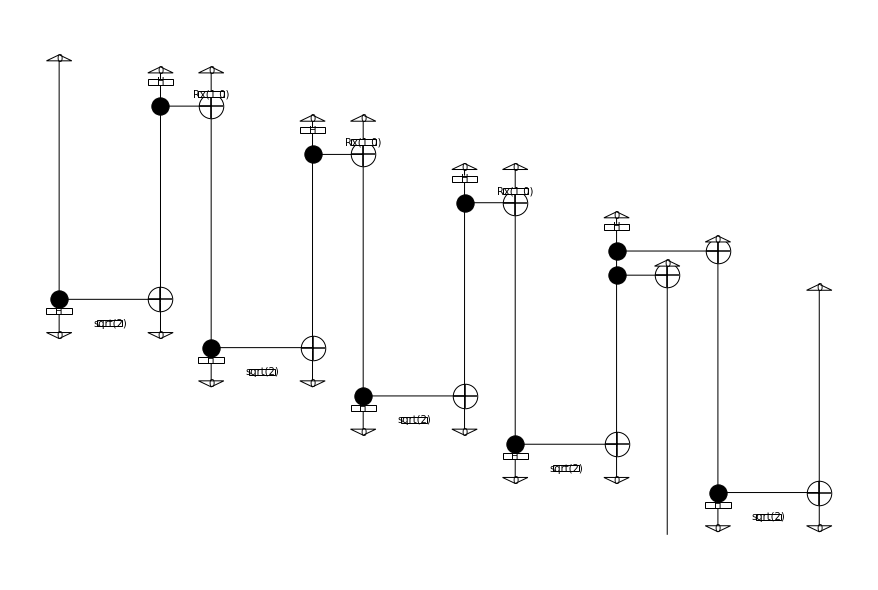


dogs don't don't don't chase cats


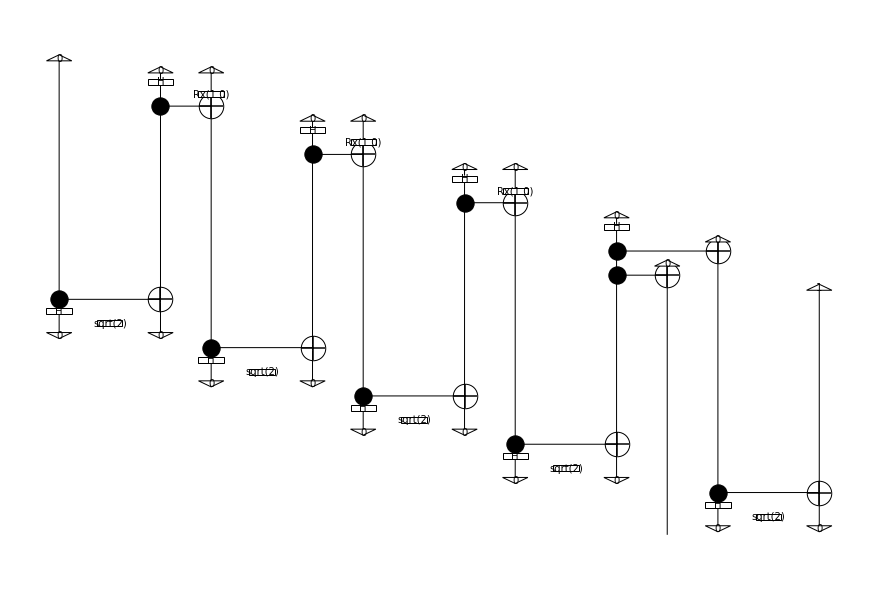


dogs don't don't don't don't purr


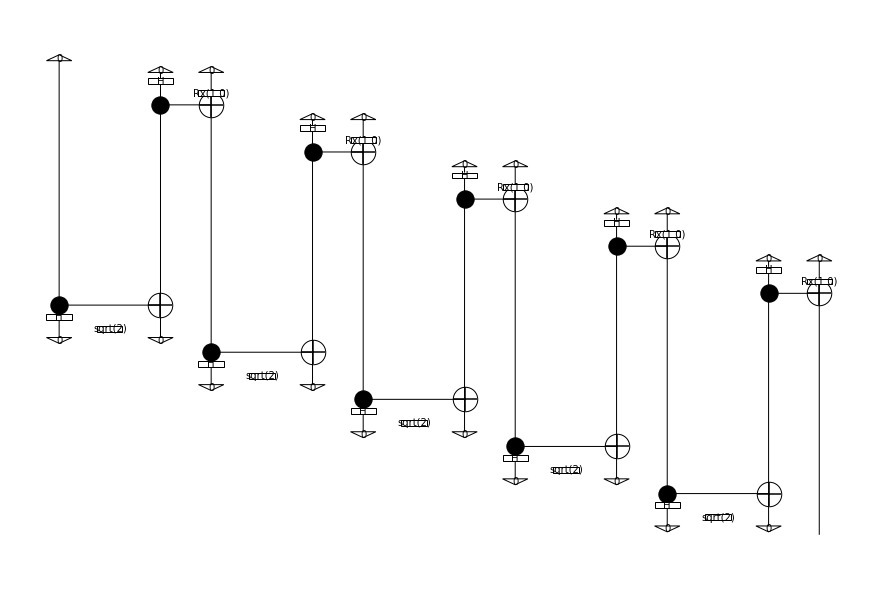


dogs don't don't purr and purr


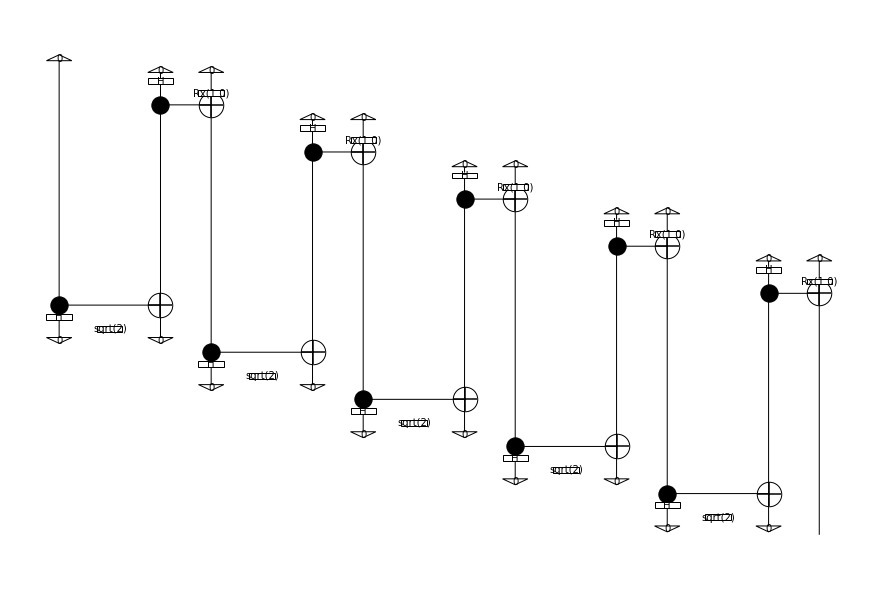


dogs don't don't purr or purr


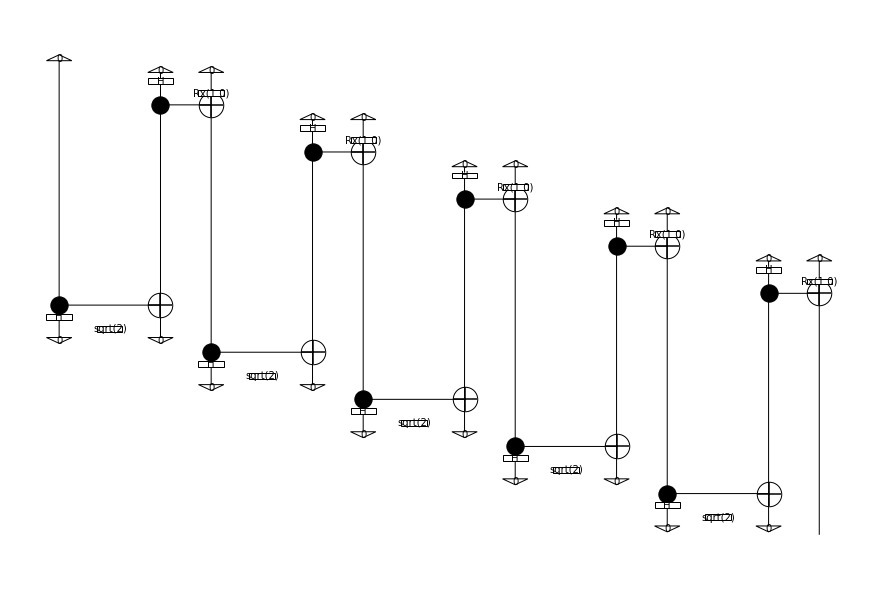


dogs don't purr and chase dogs


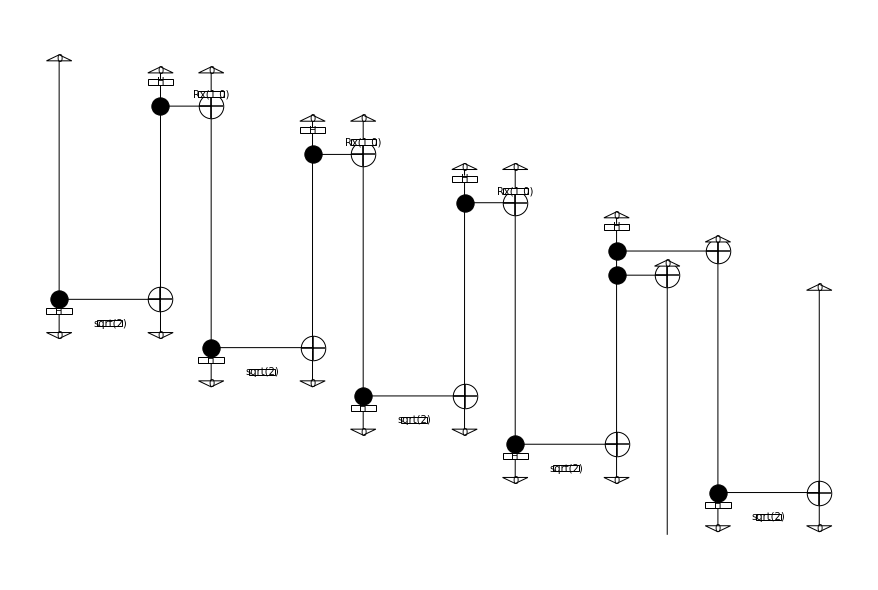


dogs don't purr and chase cats


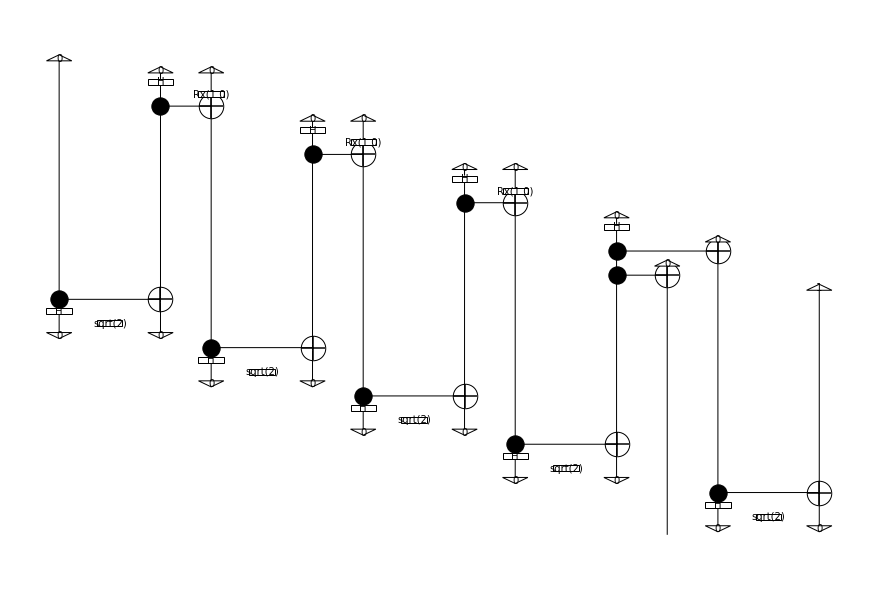


dogs don't purr and don't purr


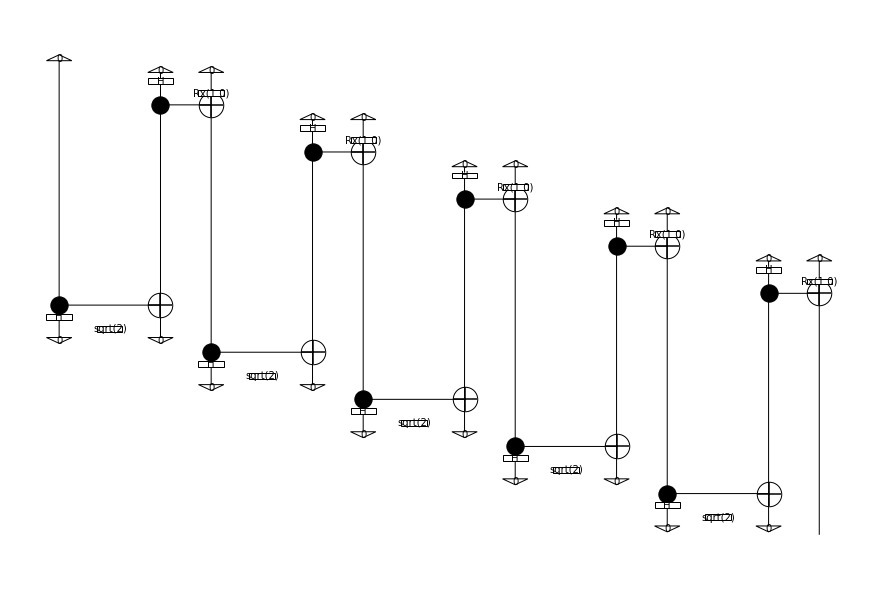


dogs don't purr or chase dogs


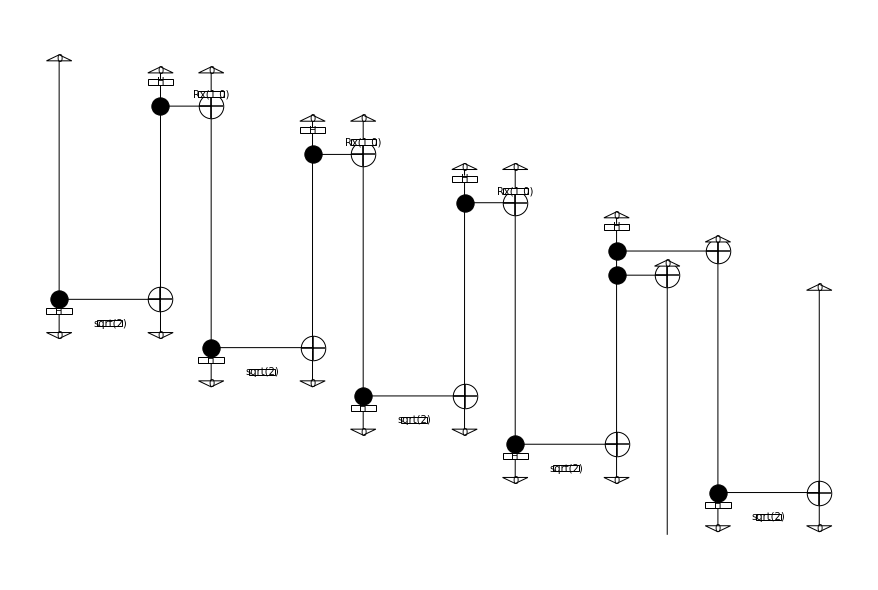


dogs don't purr or chase cats


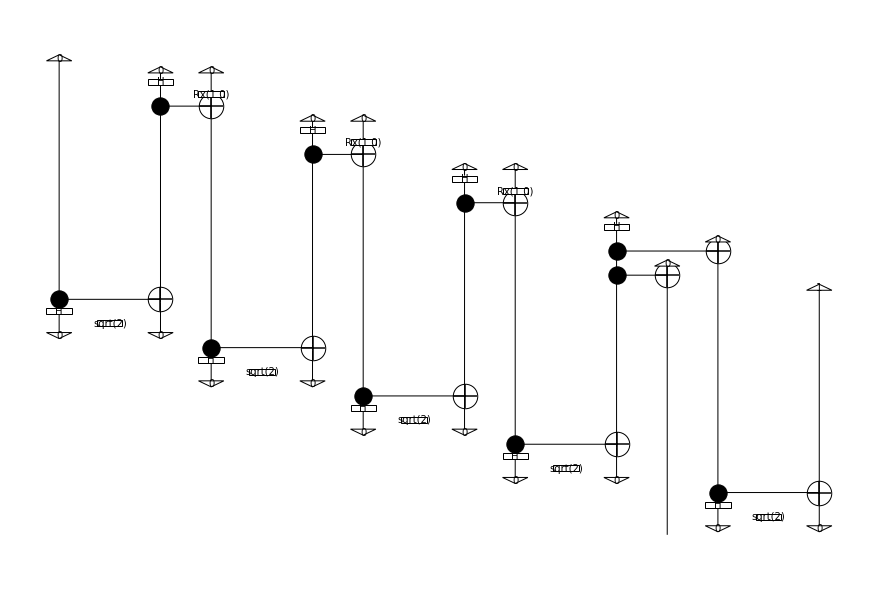


dogs don't purr or don't purr


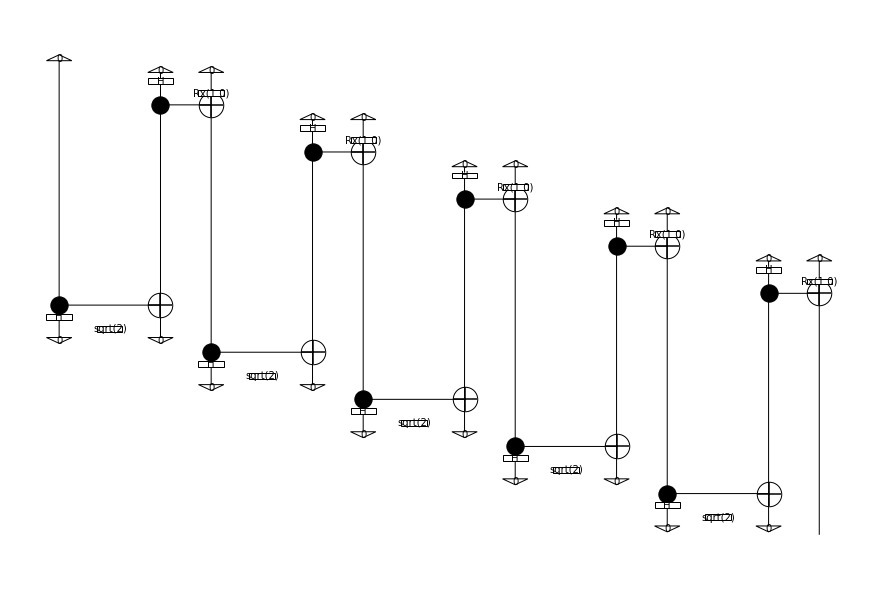


dogs purr and don't chase dogs


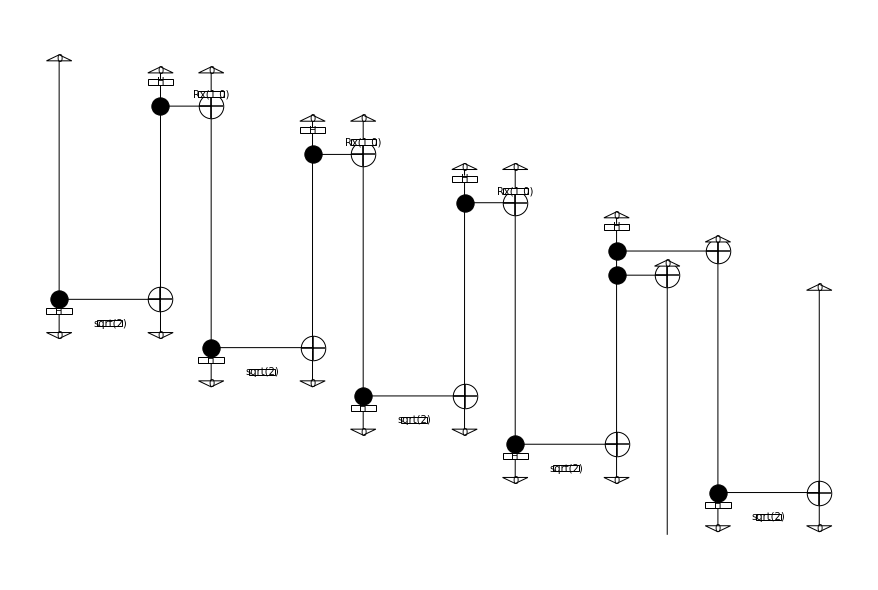


dogs purr and don't chase cats


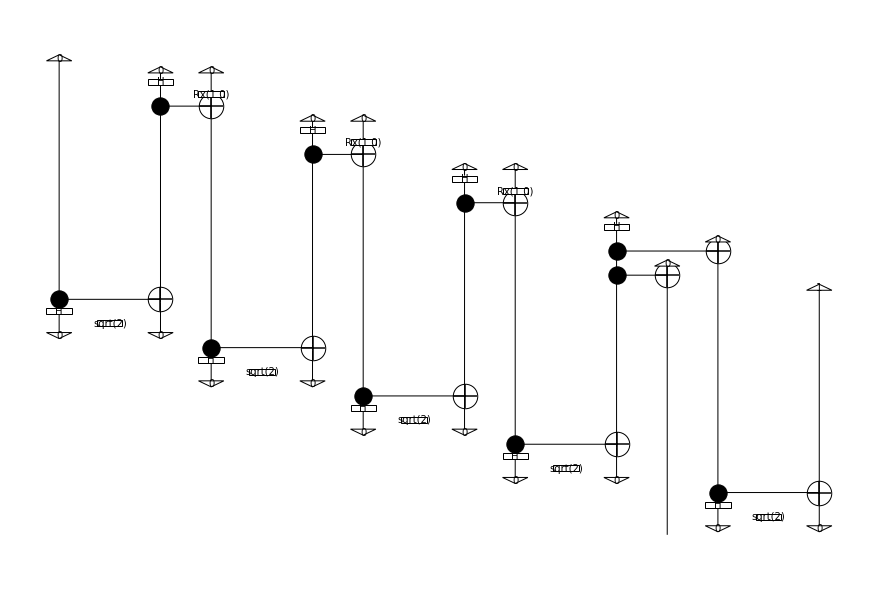


dogs purr and don't don't purr


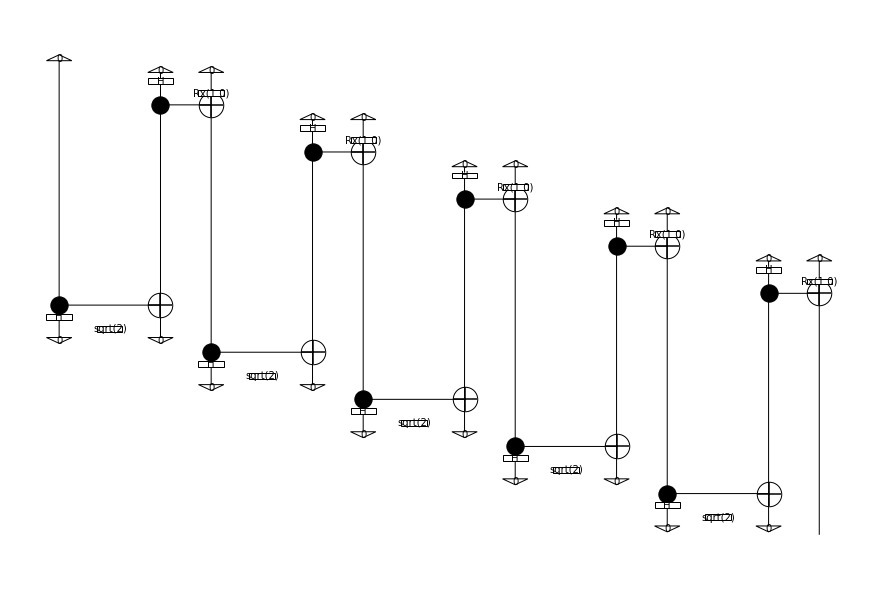


dogs purr and purr and purr


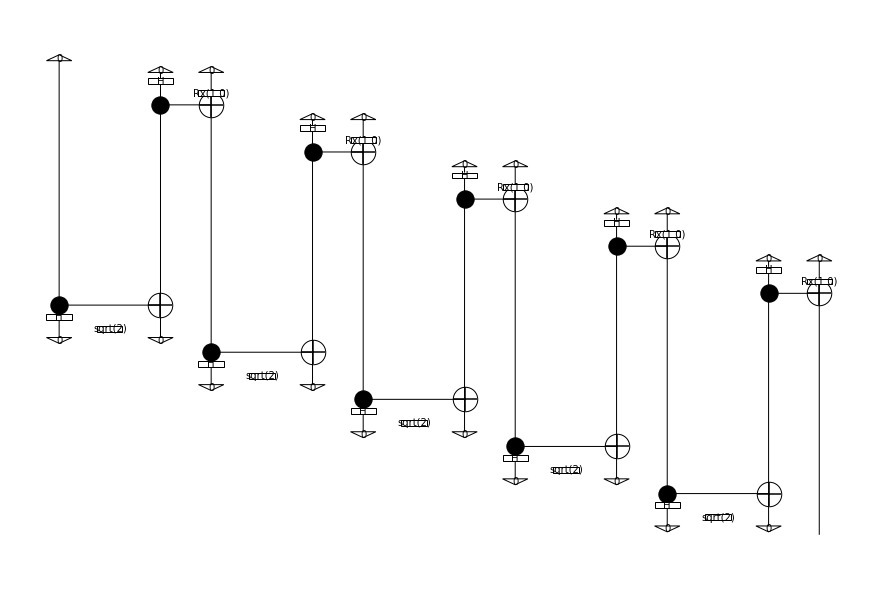


dogs purr and purr or purr


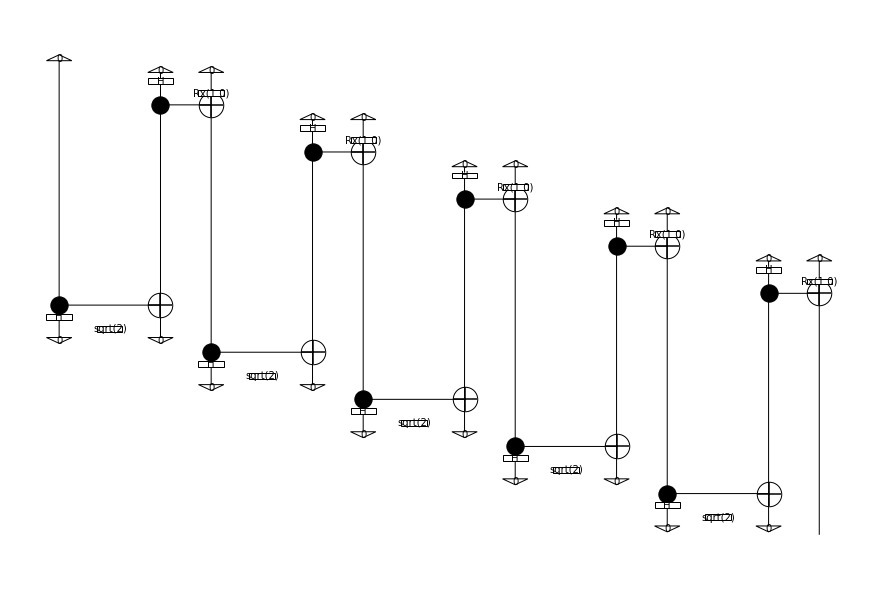


dogs purr or don't chase dogs


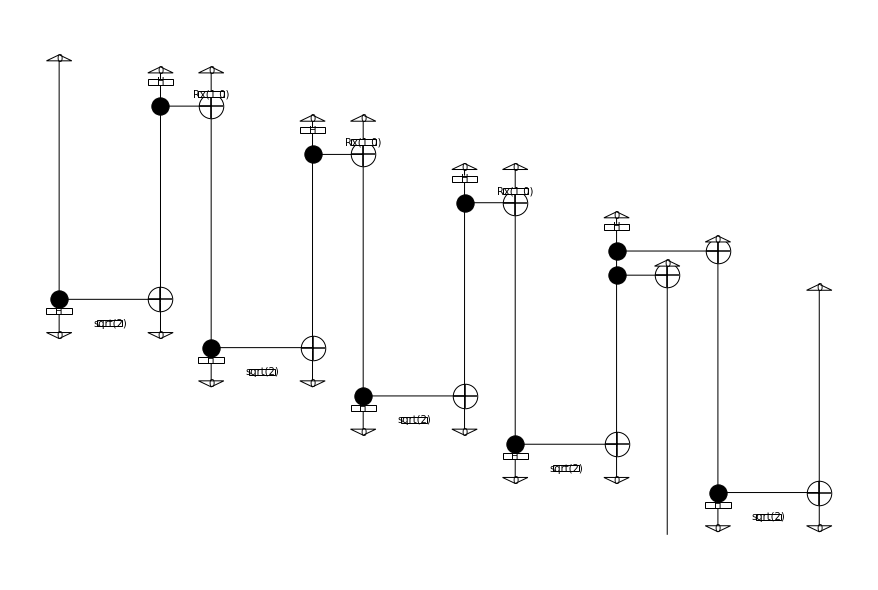


dogs purr or don't chase cats


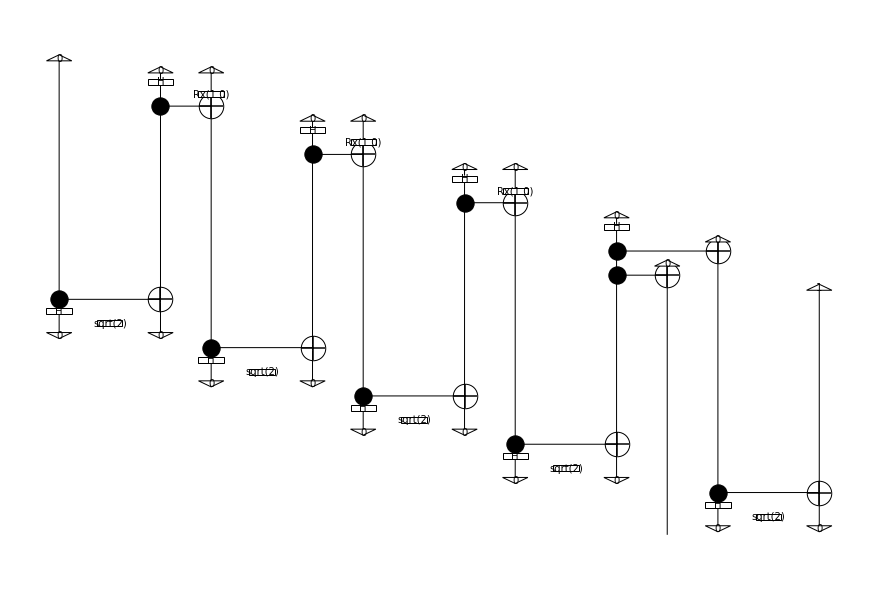


dogs purr or don't don't purr


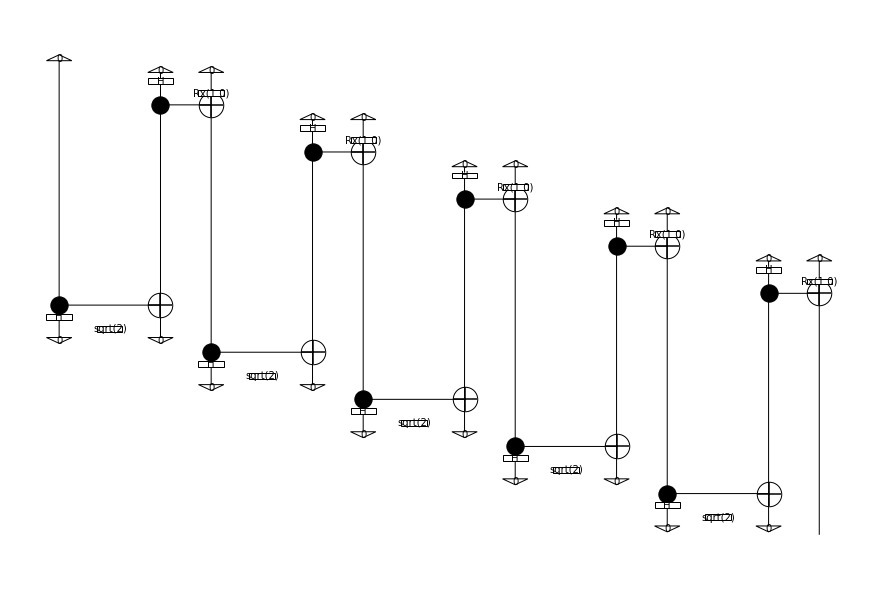


dogs purr or purr and purr


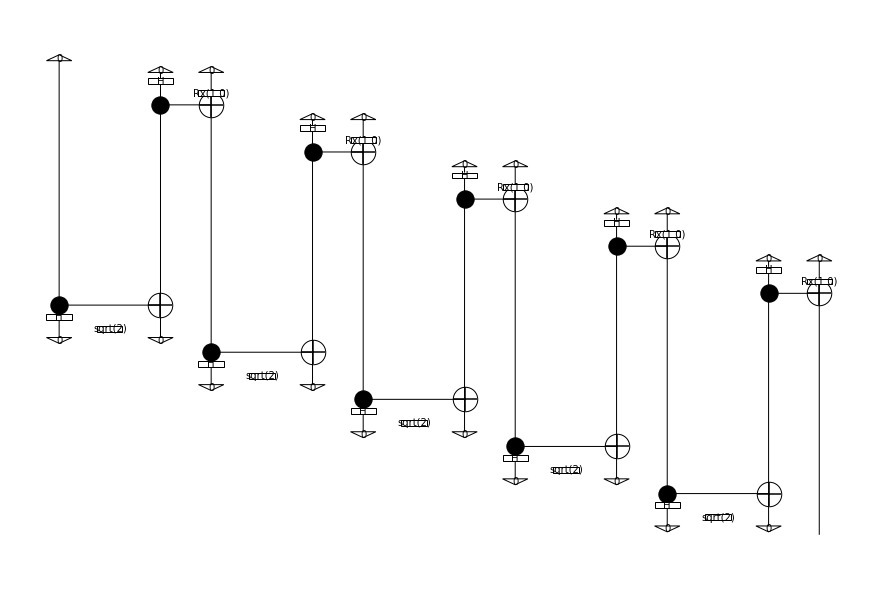


dogs purr or purr or purr


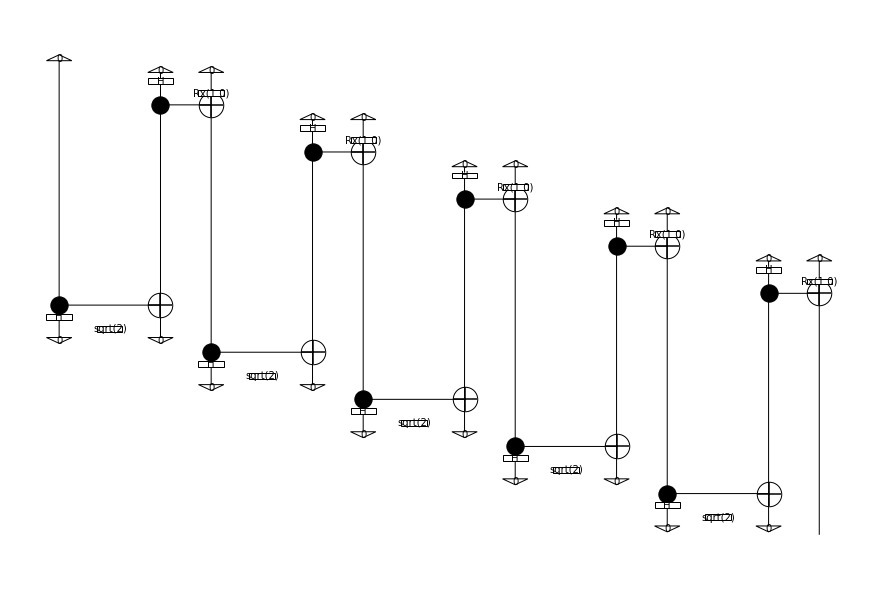


cats chase dogs and chase dogs


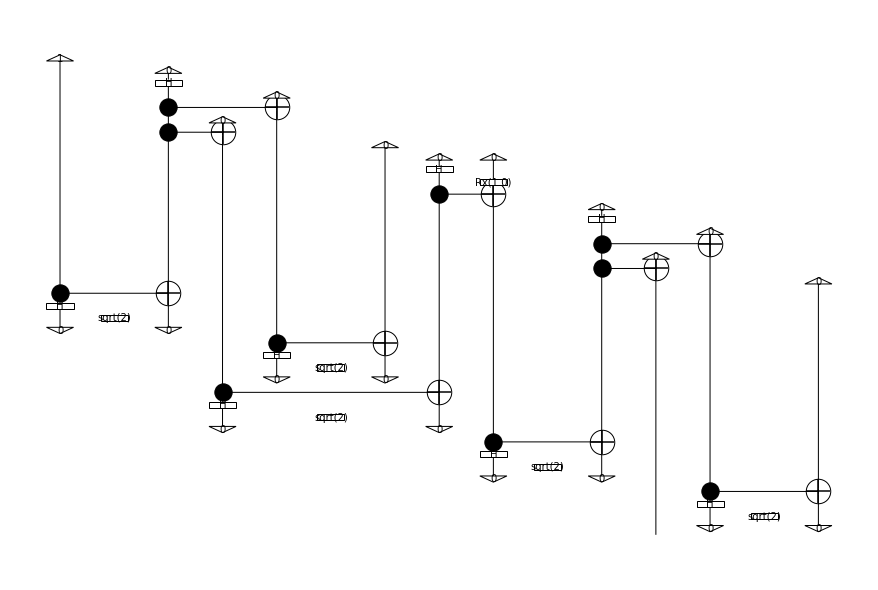


cats chase dogs and chase cats


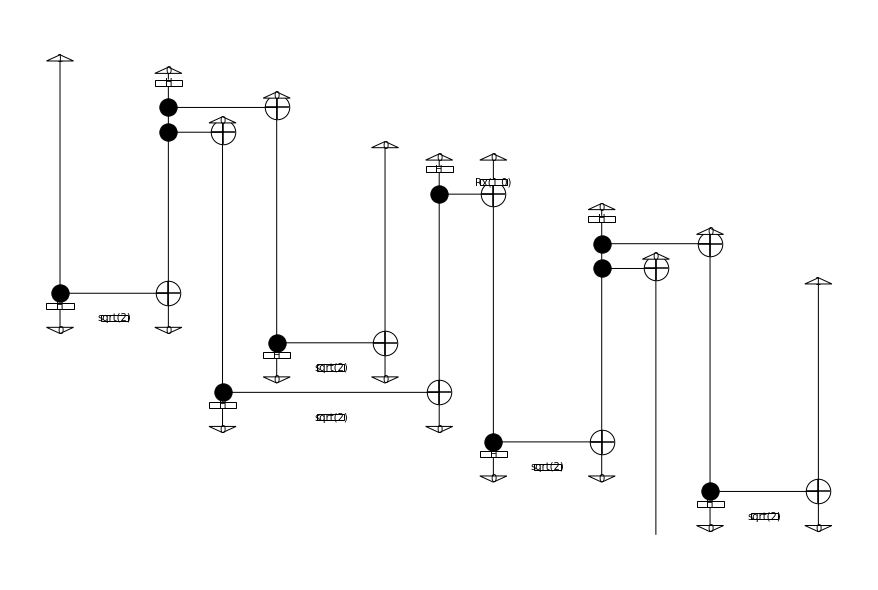


cats chase dogs and don't purr


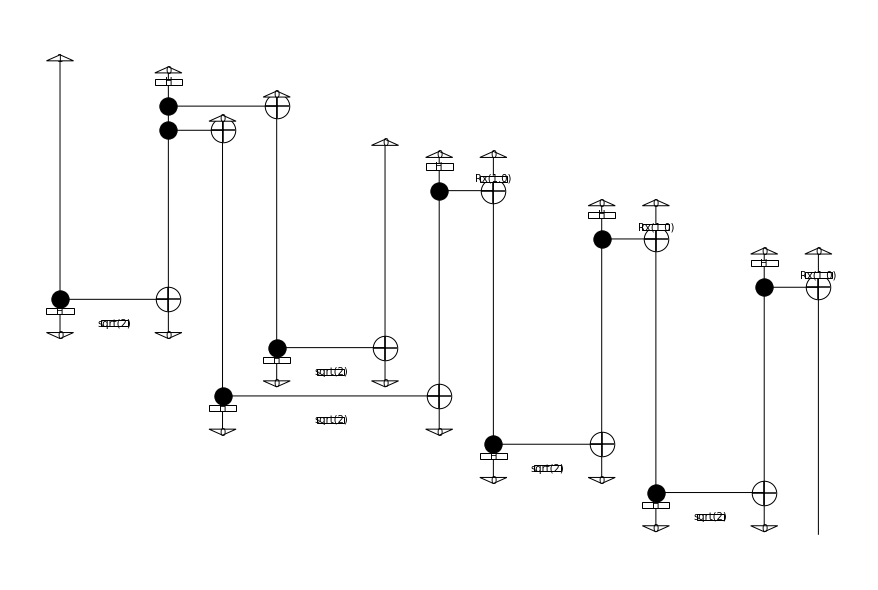


cats chase dogs or chase dogs


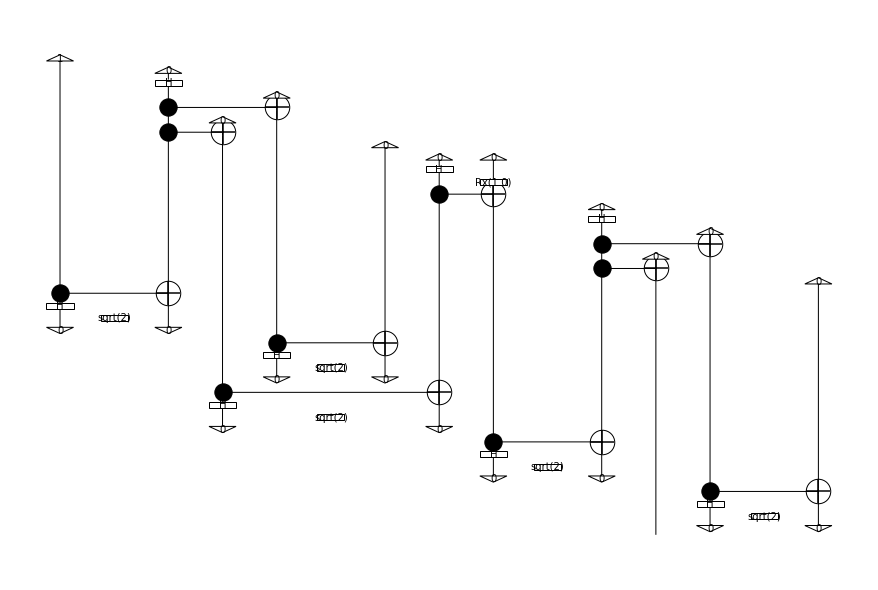


cats chase dogs or chase cats


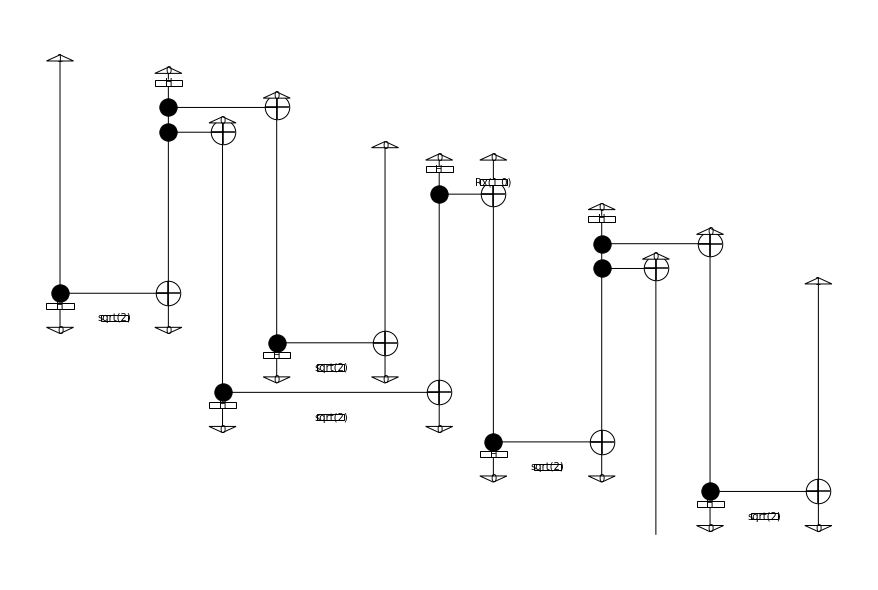


cats chase dogs or don't purr


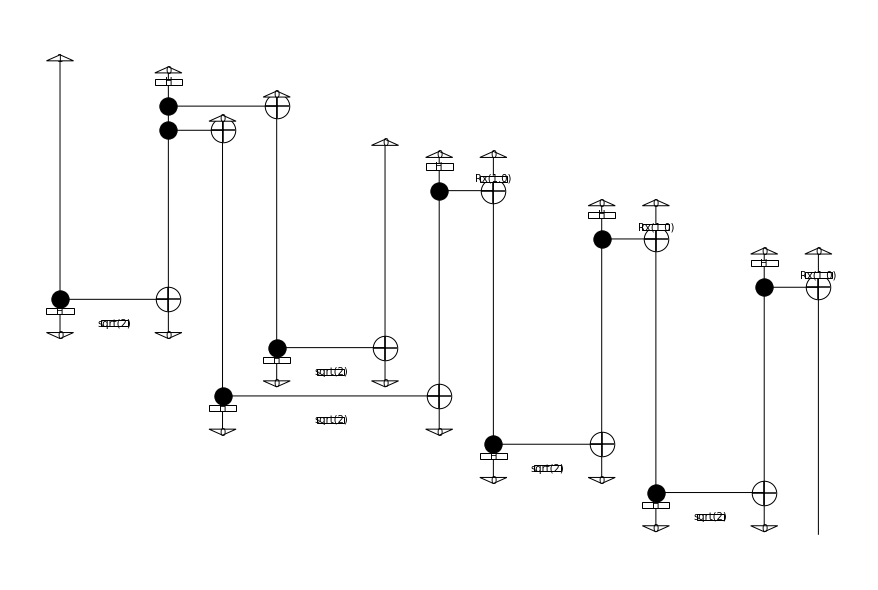


cats chase cats and chase dogs


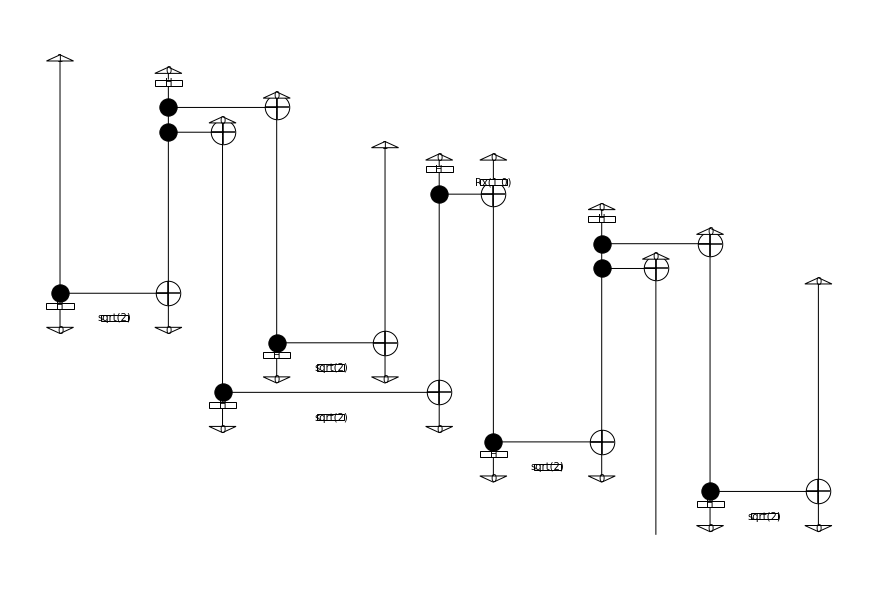


cats chase cats and chase cats


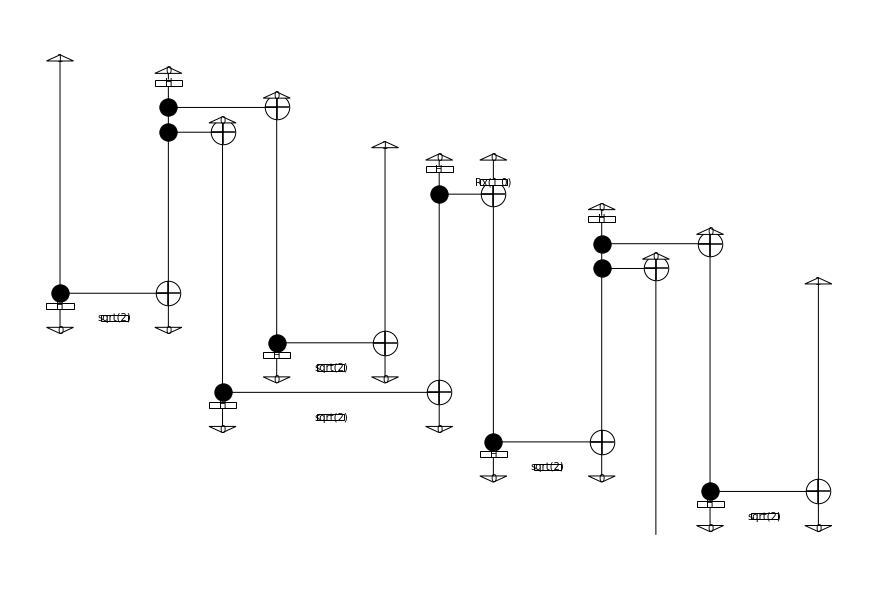


cats chase cats and don't purr


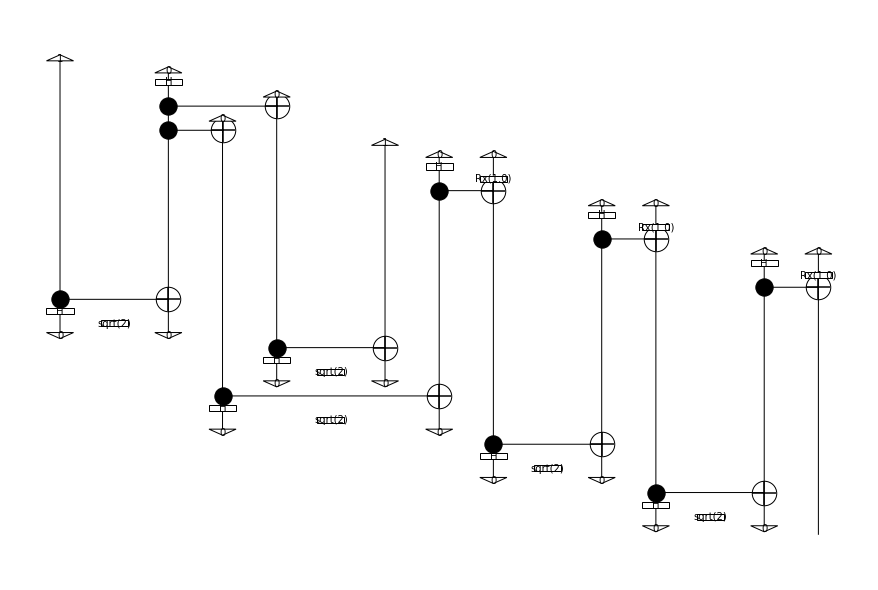


cats chase cats or chase dogs


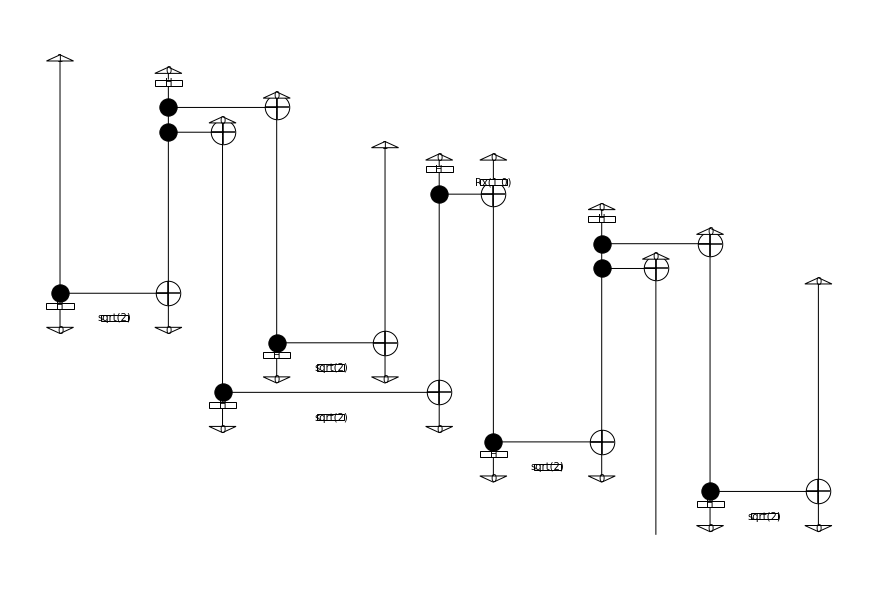


cats chase cats or chase cats


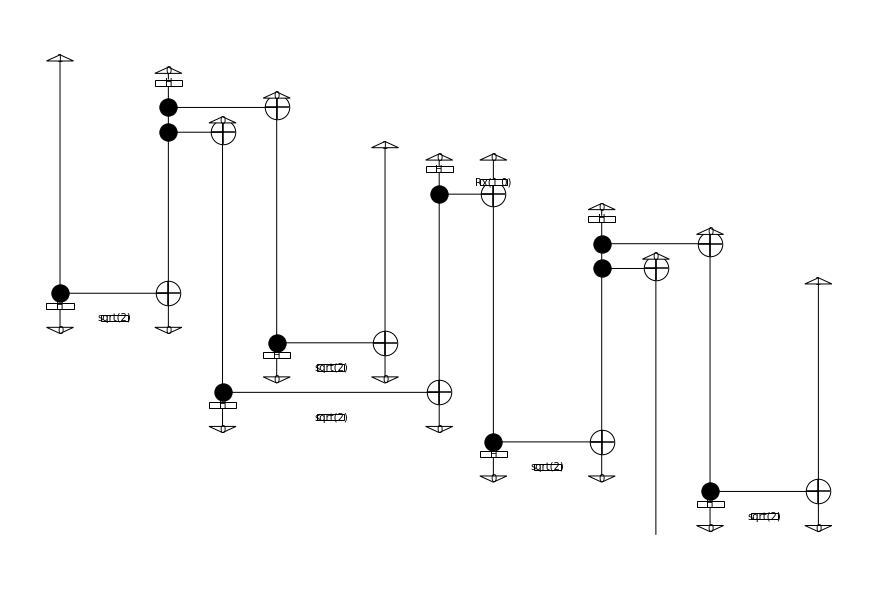


cats chase cats or don't purr


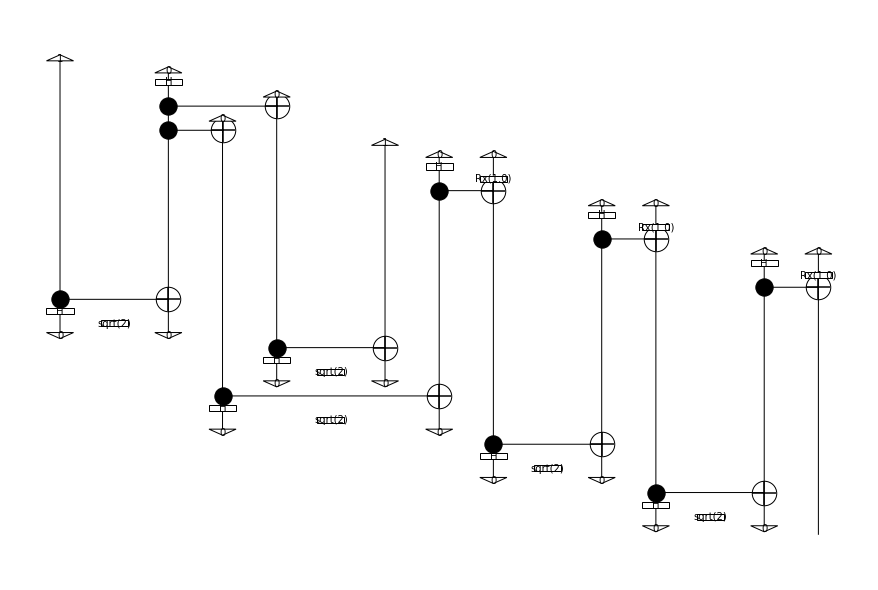


cats don't chase dogs and purr


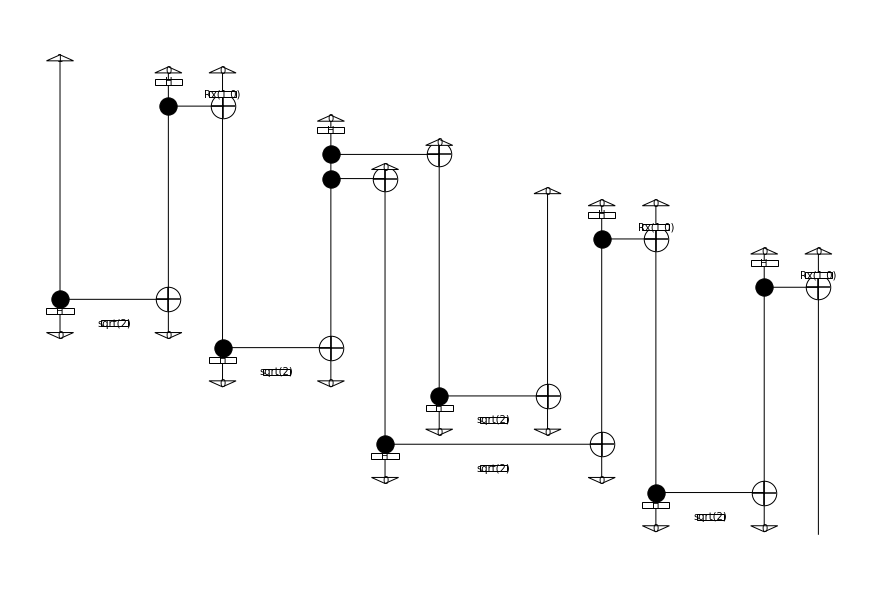


cats don't chase dogs or purr


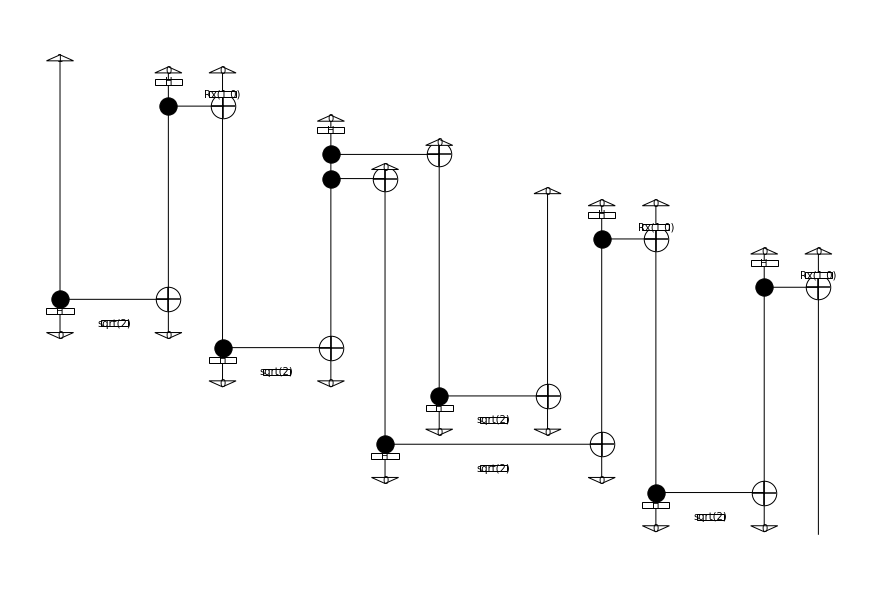


cats don't chase cats and purr


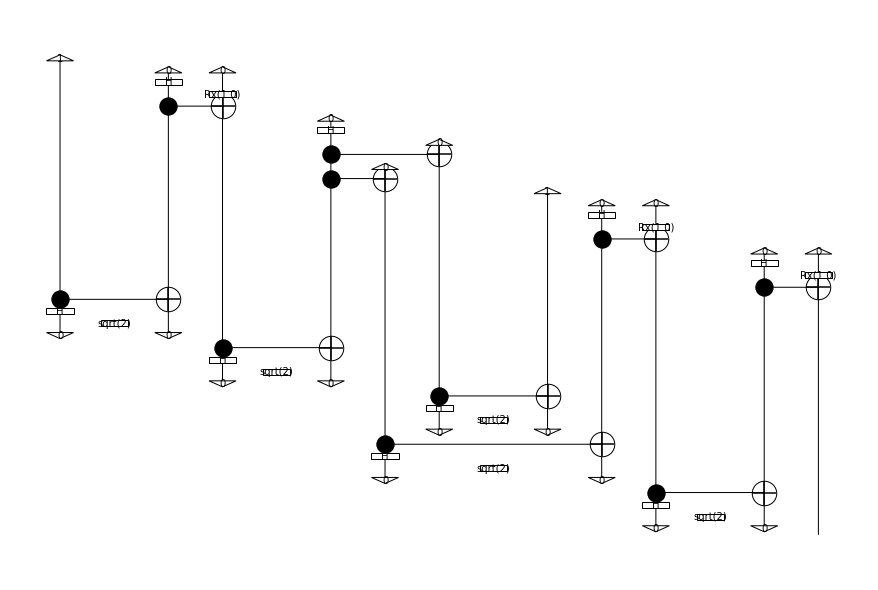

In [10]:
sentences = []
sentences2truth_values = {}
sentences2diagram = {}

csv_file = 'dataset_2.csv'
#csv_file = 'dataset_biaised.csv'
with open('datas/'+csv_file) as fp:
    for line in fp:
        line.strip("\n")
        sent_id, sentence, truth_value = line.split('\t')
        serialized_diagram = open('datas/serialized_sentences/'+sent_id, 'rb')
        diagram = pickle.loads(serialized_diagram.read())
        sentences.append(sentence)
        sentences2truth_values[sentence] = int(truth_value)
        sentences2diagram[sentence] = diagram
        #for visualization
        print(sentence)
        F(np.ones(N))(diagram).draw(figsize=(12, 8), aspect='auto', draw_type_labels=False, nodesize=1)
        print()

In [11]:
'''print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, truth_value in sentences2truth_values.items() if truth_value)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, truth_value in sentences2truth_values.items() if truth_value)))'''

True sentences:
dogs chase dogs
dogs chase cats
dogs don't purr
cats chase cats
cats don't chase dogs
cats don't don't purr
cats purr and purr
cats purr or purr
dogs chase dogs or purr
dogs chase cats or purr
dogs don't don't chase dogs
dogs don't don't chase cats
dogs don't don't don't purr
dogs don't purr or purr
dogs purr or chase dogs
dogs purr or chase cats
dogs purr or don't purr
cats chase dogs or purr
cats chase cats and purr
cats chase cats or purr
cats don't don't chase cats
cats don't purr or purr
cats purr and chase cats
cats purr or chase dogs
cats purr or chase cats
cats purr or don't purr
dogs chase dogs and chase dogs
dogs chase dogs and chase cats
dogs chase dogs and don't purr
dogs chase dogs or chase dogs
dogs chase dogs or chase cats
dogs chase dogs or don't purr
dogs chase cats and chase dogs
dogs chase cats and chase cats
dogs chase cats and don't purr
dogs chase cats or chase dogs
dogs chase cats or chase cats
dogs chase cats or don't purr
dogs don't purr and cha

In [23]:
sentence_train, sentence_test = train_test_split(sentences, test_size=0.3)

Training set size:
 ['cats chase dogs and purr', "cats don't don't chase dogs", 'dogs purr or purr or purr', "dogs don't purr and purr", 'cats chase dogs or chase dogs', "dogs don't purr and chase cats", "cats don't don't purr", "cats don't chase dogs and purr", 'cats purr or chase dogs', "dogs purr and don't chase cats", "dogs purr and don't don't purr", 'cats chase dogs and chase dogs', "dogs don't purr and don't purr", 'cats chase cats or chase dogs', 'cats purr and chase dogs', "dogs purr or don't purr", "dogs don't chase cats or purr", 'dogs purr or chase dogs', 'dogs purr', 'cats chase cats or purr', "dogs don't don't purr", 'cats chase cats and chase cats', "dogs purr or don't chase dogs", "dogs don't don't don't chase dogs", 'dogs chase dogs and purr', 'dogs chase cats and chase dogs', "cats don't purr or purr", 'cats chase dogs and chase cats', 'cats chase dogs or chase cats', "dogs don't don't purr or purr", "dogs chase cats and don't purr", 'cats chase cats and purr', 'cats 

In [12]:
def predict(params, sentence):
    output_qbit = evaluate(F(params), sentence)
    #print(output_qbit, end='\t')
    return 0 if output_qbit[0] > output_qbit[1] else 1

In [13]:
number_of_tests = 5
test_sentence = "cats don't chase dogs"
for i in range(number_of_tests):
    test_params = np.array([uniform(-1, 1) for i in range(N)])
    print("Random test_params{}: {},\t prediction: {}".format(i, test_params, predict(test_params, test_sentence)))

Random test_params0: [-0.44833019 -0.67732561 -0.57479212 -0.59574583 -0.19707485  0.83358293
  0.40464169],	 prediction: 1
Random test_params1: [-0.54097682 -0.39288778 -0.68046815  0.51924355 -0.76653214  0.35286957
  0.9381203 ],	 prediction: 1
Random test_params2: [ 0.2777272   0.40513298 -0.74043481  0.24070852 -0.51955785  0.6407269
  0.67148839],	 prediction: 1
Random test_params3: [ 0.9191216   0.44410402 -0.75752424 -0.32438386 -0.76958793 -0.74111566
 -0.21624443],	 prediction: 0
Random test_params4: [-0.25881366  0.97294816  0.65708034  0.75137763  0.97825375 -0.59066559
  0.04628042],	 prediction: 1


In [14]:
def predictions_score(params, dataset):
    count = 0
    for sentence in dataset:
        prediction = predict(params, sentence)
        actual_val = sentences2truth_values[sentence] 
        count += prediction == actual_val
    return int(count/len(sentences)*10000)/100

In [15]:
#found in https://towardsdatascience.com/the-best-way-to-pick-a-unit-vector-7bd0cc54f9b
#n being number of dimensions
def random_unit_vector(n):
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = np.array([x/r for x in components])
    return v

In [16]:
#random descent
number_of_tests = 10

size_step = 0.25
test_params = np.array([uniform(-1, 1) for i in range(N)])

best_score = 0
best_params = test_params

for i in range(number_of_tests):
    #calculate score
    score = predictions_score(test_params)

    #update best score
    if score > best_score:
        best_score = score
        best_params = test_params
        
        #print updated score
        print("Params at step {}: {},\t score: {} %".format(i, test_params, score))
        
    #make a step
    step = random_unit_vector(N)*size_step
    test_params = best_params + step

print("---------\nBest params found: {},\t score: {} %".format(best_params, best_score))

Params at step 0: [ 0.14280519 -0.14222189  0.1561826  -0.58780354  0.6266425   0.64717775
  0.30694507],	 score: 52.0 %
Params at step 1: [ 0.2828787  -0.06697959 -0.00638261 -0.58868546  0.69200267  0.57142982
  0.33487501],	 score: 55.0 %
Params at step 5: [ 0.24220205  0.0249772  -0.0464698  -0.67106045  0.71190375  0.50002703
  0.53109511],	 score: 58.0 %
---------
Best params found: [ 0.24220205  0.0249772  -0.0464698  -0.67106045  0.71190375  0.50002703
  0.53109511],	 score: 58.0 %


In [17]:
#bruteforcing randomly through grid search
'''seed(3.14)

number_of_tests = 5
number_of_test_printed = 10

best_score = 0
best_params = None

for i in range(number_of_tests):
    #calculate score
    test_params = np.array([uniform(-1, 1), uniform(-1, 1), uniform(-1, 1), uniform(-1, 1), uniform(-1, 1)])
    score = predictions_score(test_params)
    
    #print first and last ones
    print("Random test_params{}: {},\t score: {} %".format(i, test_params, score))

    #update best score
    if score > best_score:
        best_score = score
        best_params = test_params

print("---------\nBest test_params: {},\t score: {} %".format(best_params, best_score))'''

'seed(3.14)\n\nnumber_of_tests = 5\nnumber_of_test_printed = 10\n\nbest_score = 0\nbest_params = None\n\nfor i in range(number_of_tests):\n    #calculate score\n    test_params = np.array([uniform(-1, 1), uniform(-1, 1), uniform(-1, 1), uniform(-1, 1), uniform(-1, 1)])\n    score = predictions_score(test_params)\n    \n    #print first and last ones\n    print("Random test_params{}: {},\t score: {} %".format(i, test_params, score))\n\n    #update best score\n    if score > best_score:\n        best_score = score\n        best_params = test_params\n\nprint("---------\nBest test_params: {},\t score: {} %".format(best_params, best_score))'

In [18]:
#found bruteforcing randomly through grid search
best_params_ever = np.array([0.55089768, 0.43491375, -0.58409627, 0.22894581, 0.98844909])
best_score_ever = predictions_score(best_params_ever)
print("---------\nBest params ever: {},\t score: {} %".format(best_params_ever, best_score_ever))

---------
Best params ever: [ 0.55089768  0.43491375 -0.58409627  0.22894581  0.98844909],	 score: 60.0 %
